<h1 align=center>CS-370: Project 2 by Maurice Wesley</h1>

Using TensorFlow backend.


reward= -0.04


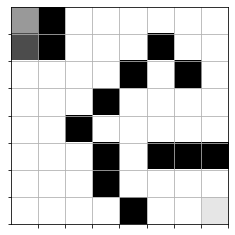

In [1]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline

# 8 x 8 numpy Array for graph traversal 
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

# Member method to show agent and maze
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

# Agent actions
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Exploration factor
epsilon = 0.1

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)

# Instantiate Treasure Maze instance for testing
qmaze = TreasureMaze(maze)

# Test movement of agent in down direction
canvas, reward, game_over = qmaze.act(DOWN)

# Output reward to agent
print("reward=", reward)

# Show movement of agent in the down direction in maze
show(qmaze)

# Member function to check an instance of the game
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False
        
# Member function for completion check
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

# Member function to build model
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

# Member function to train model
def qtrain(model, maze, **opt):

    # exploration factor
    global epsilon

    # number of epochs
    n_epoch = opt.get('n_epoch', 10000)
    num_epoch = 10

    # maximum memory to store episodes
    max_memory = opt.get('max_memory', 1000)

    # maximum data size for training
    data_size = opt.get('data_size', 50)

    # start time
    start_time = datetime.datetime.now()

    # Construct environment/game from numpy array: maze (see above)
    qmaze = TreasureMaze(maze)

    # Initialize experience replay object
    experience = GameExperience(model, max_memory=max_memory)
    
    # history of win/lose game
    win_history = []   
    
    # history window size
    hsize = qmaze.maze.size//2   
    
    # Sum of the win_history contents devided by length of the list
    win_rate = 0.0
    
    # Loop for each epoch
    for epoch in range(n_epoch):
        # Declare and assign variable to random free cell
        agent_cell = random.choice(qmaze.free_cells)
    
        # Reset the maze with agent set to above position
        qmaze.reset(agent_cell)

        # Set the environment variable to the current state
        envstate = qmaze.observe()
        
        # Declare variable for loss
        Loss = 0
        
        # Declare variable to track number of episodes
        n_episodes = 0

        # While state is not game over:
        while qmaze.game_status() == "not_over":
            
            # Declare variable to store the previous state
            previous_envstate = envstate
            
            # Randomly choose action (exploration or exploitation) based on episilon
            if np.random.rand() < epsilon:
                
                # When true, randomly choose action from valid actions based on cell
                action = random.choice(qmaze.valid_actions((qmaze.state[0], qmaze.state[1])))
                
            else:
                
                # When false, action predicted from experience 
                action = np.argmax(experience.predict(envstate))
                
            # Declare and assign variables to action attributes
            envstate, reward, game_status = qmaze.act(action)
        
            # Declare list variable and store the episode's attributes
            episode = [previous_envstate, action, reward, envstate, game_status]
    
            # Store episode in Experience replay object
            experience.remember(episode)
            
            # Increment number of episodes in game
            n_episodes += 1
    
            # Call Game Experience member method to retrieve training data
            ex_input, target = experience.get_data()
            
            # Train the neural network model
            model.fit(ex_input, target, batch_size=data_size, verbose = 0)
            
            # Call model member method evaluate to determine loss
            Loss = model.evaluate(ex_input, target)
            
        #Print the epoch, loss, episodes, win count, time, and win rate for each epoch
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        
        # Condition to check the game status
        if game_status == 'win':
            
            # add 1 when the agent won
            win_history.append(1)
            
        else:
            
            # add 0 when the agent lost
            win_history.append(0)
        
        # Equation to calculate the win rate
        win_rate = sum(win_history) / len(win_history)
        
        # Output to user
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch + 1, n_epoch, Loss, n_episodes, sum(win_history), win_rate, t))
        
        # Change epsilon based on win rate
        if win_rate > 0.9 : epsilon = 0.05

        # We simply check if training has exhausted all free cells
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            
            # if in all cases the agent won.
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break
    
    
    # Determine the total time for training
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    
    # If the win rate is above the threshold and your model passes the completion check, that would be your epoch.
    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch + 1, max_memory, data_size, t))
    return seconds

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)
    

In [3]:
# Initialize Treasure Maze object
qmaze = TreasureMaze(maze)

# Maze instance for testing
model = build_model(maze)

# Variable to store pirate location
pirate_cell = (0,0)

# Run single instance of game for testing
play_game(model, qmaze, pirate_cell)

False

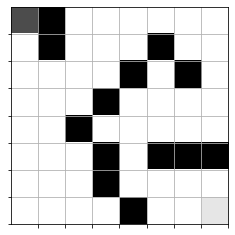

In [4]:
# Initialize Treasure Maze object
qmaze = TreasureMaze(maze)

# Output maze to user
show(qmaze)

In [5]:
# Neuro Network
model = build_model(maze)

# Train Model
qtrain(model, maze, n_epoch=10000, max_memory=8*maze.size, data_size=32)

10/10 [==============================] - 0s 100us/step
Epoch: 001/10000 | Loss: 0.0018 | Episodes: 135 | Win count: 0 | Win rate: 0.000 | time: 6.2 seconds
10/10 [==============================] - 0s 398us/step


10/10 [==============================] - 0s 99us/step
Epoch: 002/10000 | Loss: 0.0004 | Episodes: 145 | Win count: 0 | Win rate: 0.000 | time: 10.2 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 97us/step
Epoch: 003/10000 | Loss: 0.0011 | Episodes: 138 | Win count: 0 | Win rate: 0.000 | time: 14.5 seconds
10/10 [==============================] - 0s 98us/step


10/10 [==============================] - 0s 400us/step
Epoch: 004/10000 | Loss: 0.0015 | Episodes: 134 | Win count: 0 | Win rate: 0.000 | time: 18.9 seconds
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 101us/step
Epoch: 005/10000 | Loss: 0.0026 | Episodes: 140 | Win count: 0 | Win rate: 0.000 | time: 23.3 seconds
10/10 [==============================] - 0s 401us/step


10/10 [==============================] - 0s 99us/step
Epoch: 006/10000 | Loss: 0.0001 | Episodes: 145 | Win count: 0 | Win rate: 0.000 | time: 27.6 seconds
10/10 [==============================] - 0s 202us/step


10/10 [==============================] - 0s 0us/step
Epoch: 007/10000 | Loss: 0.0024 | Episodes: 139 | Win count: 0 | Win rate: 0.000 | time: 31.7 seconds
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 98us/step
Epoch: 008/10000 | Loss: 0.0001 | Episodes: 145 | Win count: 0 | Win rate: 0.000 | time: 36.1 seconds
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 495us/step
Epoch: 009/10000 | Loss: 0.0052 | Episodes: 141 | Win count: 0 | Win rate: 0.000 | time: 40.6 seconds
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 358us/step
Epoch: 010/10000 | Loss: 0.0010 | Episodes: 141 | Win count: 0 | Win rate: 0.000 | time: 45.2 seconds
10/10 [==============================] - 0s 200us/step


10/10 [==============================] - 0s 105us/step
Epoch: 011/10000 | Loss: 0.0013 | Episodes: 143 | Win count: 0 | Win rate: 0.000 | time: 50.0 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 0us/step
Epoch: 012/10000 | Loss: 0.0017 | Episodes: 146 | Win count: 0 | Win rate: 0.000 | time: 54.6 seconds
10/10 [==============================] - 0s 695us/step
Epoch: 013/10000 | Loss: 0.0010 | Episodes: 9 | Win count: 1 | Win rate: 0.077 | time: 54.9 seconds
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 101us/step
Epoch: 014/10000 | Loss: 0.0009 | Episodes: 139 | Win count: 1 | Win rate: 0.071 | time: 59.5 seconds
10/10 [==============================] - 0s 196us/step


10/10 [==============================] - 0s 103us/step
Epoch: 015/10000 | Loss: 0.0018 | Episodes: 146 | Win count: 1 | Win rate: 0.067 | time: 64.0 seconds
10/10 [==============================] - 0s 95us/step


10/10 [==============================] - 0s 100us/step
Epoch: 016/10000 | Loss: 0.0011 | Episodes: 141 | Win count: 1 | Win rate: 0.062 | time: 68.2 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 198us/step
Epoch: 017/10000 | Loss: 0.0000 | Episodes: 140 | Win count: 1 | Win rate: 0.059 | time: 72.5 seconds
10/10 [==============================] - 0s 102us/step


10/10 [==============================] - 0s 101us/step
Epoch: 018/10000 | Loss: 0.0016 | Episodes: 140 | Win count: 1 | Win rate: 0.056 | time: 76.9 seconds
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 100us/step
Epoch: 019/10000 | Loss: 0.0010 | Episodes: 137 | Win count: 1 | Win rate: 0.053 | time: 81.0 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 020/10000 | Loss: 0.0009 | Episodes: 2 | Win count: 2 | Win rate: 0.100 | time: 81.1 seconds
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 101us/step
Epoch: 021/10000 | Loss: 0.0006 | Episodes: 146 | Win count: 2 | Win rate: 0.095 | time: 85.7 seconds
10/10 [==============================] - 0s 96us/step
Epoch: 022/10000 | Loss: 0.0342 | Episodes: 137 | Win count: 2 | Win rate: 0.091 | time: 90.0 seconds
10/10 [==============================] - 0s 98us/step


10/10 [==============================] - 0s 100us/step
Epoch: 023/10000 | Loss: 0.0010 | Episodes: 142 | Win count: 2 | Win rate: 0.087 | time: 94.3 seconds
10/10 [==============================] - 0s 69us/step


10/10 [==============================] - 0s 0us/step
Epoch: 024/10000 | Loss: 0.0010 | Episodes: 149 | Win count: 2 | Win rate: 0.083 | time: 99.1 seconds
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 125us/step
Epoch: 025/10000 | Loss: 0.0021 | Episodes: 141 | Win count: 2 | Win rate: 0.080 | time: 103.4 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 118us/step
Epoch: 026/10000 | Loss: 0.0028 | Episodes: 142 | Win count: 2 | Win rate: 0.077 | time: 107.6 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 106us/step
Epoch: 027/10000 | Loss: 0.0033 | Episodes: 142 | Win count: 2 | Win rate: 0.074 | time: 112.2 seconds
10/10 [==============================] - 0s 114us/step


10/10 [==============================] - 0s 111us/step
Epoch: 028/10000 | Loss: 0.0002 | Episodes: 137 | Win count: 2 | Win rate: 0.071 | time: 116.6 seconds
10/10 [==============================] - 0s 504us/step


10/10 [==============================] - 0s 0us/step
Epoch: 029/10000 | Loss: 0.0010 | Episodes: 139 | Win count: 2 | Win rate: 0.069 | time: 120.7 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 030/10000 | Loss: 0.0010 | Episodes: 12 | Win count: 3 | Win rate: 0.100 | time: 121.1 seconds
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 311us/step
Epoch: 031/10000 | Loss: 0.0002 | Episodes: 141 | Win count: 3 | Win rate: 0.097 | time: 125.4 seconds
10/10 [==============================] - 0s 105us/step


10/10 [==============================] - 0s 100us/step
Epoch: 032/10000 | Loss: 0.0010 | Episodes: 144 | Win count: 3 | Win rate: 0.094 | time: 130.2 seconds
10/10 [==============================] - 0s 197us/step
Epoch: 033/10000 | Loss: 0.0008 | Episodes: 37 | Win count: 4 | Win rate: 0.121 | time: 131.4 seconds
10/10 [==============================] - 0s 98us/step


10/10 [==============================] - 0s 200us/step
Epoch: 034/10000 | Loss: 0.0028 | Episodes: 135 | Win count: 4 | Win rate: 0.118 | time: 136.0 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 99us/step
Epoch: 035/10000 | Loss: 0.0012 | Episodes: 139 | Win count: 4 | Win rate: 0.114 | time: 140.5 seconds
10/10 [==============================] - 0s 89us/step


10/10 [==============================] - 0s 101us/step
Epoch: 036/10000 | Loss: 0.0028 | Episodes: 140 | Win count: 4 | Win rate: 0.111 | time: 145.1 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 100us/step
Epoch: 037/10000 | Loss: 0.0009 | Episodes: 137 | Win count: 4 | Win rate: 0.108 | time: 149.6 seconds
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 99us/step
Epoch: 038/10000 | Loss: 0.0009 | Episodes: 152 | Win count: 4 | Win rate: 0.105 | time: 154.4 seconds
10/10 [==============================] - 0s 97us/step


10/10 [==============================] - 0s 103us/step
Epoch: 039/10000 | Loss: 0.0024 | Episodes: 141 | Win count: 4 | Win rate: 0.103 | time: 158.7 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 0us/step
Epoch: 040/10000 | Loss: 0.0010 | Episodes: 146 | Win count: 4 | Win rate: 0.100 | time: 163.5 seconds
10/10 [==============================] - 0s 835us/step


10/10 [==============================] - 0s 102us/step
Epoch: 041/10000 | Loss: 0.0012 | Episodes: 139 | Win count: 4 | Win rate: 0.098 | time: 168.6 seconds
10/10 [==============================] - 0s 113us/step


10/10 [==============================] - 0s 100us/step
Epoch: 042/10000 | Loss: 0.0028 | Episodes: 139 | Win count: 4 | Win rate: 0.095 | time: 173.1 seconds
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 99us/step
Epoch: 043/10000 | Loss: 0.0010 | Episodes: 142 | Win count: 4 | Win rate: 0.093 | time: 177.9 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 301us/step
Epoch: 044/10000 | Loss: 0.0021 | Episodes: 147 | Win count: 4 | Win rate: 0.091 | time: 182.7 seconds
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 99us/step
Epoch: 045/10000 | Loss: 0.0011 | Episodes: 139 | Win count: 4 | Win rate: 0.089 | time: 187.4 seconds
10/10 [==============================] - 0s 201us/step


10/10 [==============================] - 0s 110us/step
Epoch: 046/10000 | Loss: 0.0010 | Episodes: 140 | Win count: 4 | Win rate: 0.087 | time: 191.6 seconds
10/10 [==============================] - 0s 96us/step


10/10 [==============================] - 0s 99us/step
Epoch: 047/10000 | Loss: 0.0001 | Episodes: 143 | Win count: 4 | Win rate: 0.085 | time: 196.0 seconds
10/10 [==============================] - 0s 98us/step


10/10 [==============================] - 0s 0us/step
Epoch: 048/10000 | Loss: 0.0015 | Episodes: 140 | Win count: 4 | Win rate: 0.083 | time: 200.2 seconds
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 96us/step
Epoch: 049/10000 | Loss: 0.0001 | Episodes: 144 | Win count: 4 | Win rate: 0.082 | time: 204.4 seconds
10/10 [==============================] - 0s 37us/step
Epoch: 050/10000 | Loss: 0.0009 | Episodes: 25 | Win count: 5 | Win rate: 0.100 | time: 205.2 seconds
10/10 [==============================] - 0s 177us/step


10/10 [==============================] - 0s 198us/step
Epoch: 051/10000 | Loss: 0.0017 | Episodes: 137 | Win count: 5 | Win rate: 0.098 | time: 209.2 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 102us/step
Epoch: 052/10000 | Loss: 0.0010 | Episodes: 137 | Win count: 5 | Win rate: 0.096 | time: 213.6 seconds
10/10 [==============================] - 0s 322us/step


10/10 [==============================] - 0s 102us/step
Epoch: 053/10000 | Loss: 0.0026 | Episodes: 145 | Win count: 5 | Win rate: 0.094 | time: 218.3 seconds
10/10 [==============================] - 0s 508us/step


10/10 [==============================] - 0s 298us/step
Epoch: 054/10000 | Loss: 0.0003 | Episodes: 144 | Win count: 5 | Win rate: 0.093 | time: 222.5 seconds
10/10 [==============================] - 0s 381us/step


10/10 [==============================] - 0s 166us/step
Epoch: 055/10000 | Loss: 0.0016 | Episodes: 151 | Win count: 5 | Win rate: 0.091 | time: 227.2 seconds
10/10 [==============================] - 0s 94us/step
Epoch: 056/10000 | Loss: 0.0002 | Episodes: 138 | Win count: 5 | Win rate: 0.089 | time: 231.6 seconds
10/10 [==============================] - 0s 201us/step


10/10 [==============================] - 0s 136us/step
Epoch: 057/10000 | Loss: 0.0022 | Episodes: 149 | Win count: 5 | Win rate: 0.088 | time: 236.2 seconds
10/10 [==============================] - 0s 95us/step


10/10 [==============================] - 0s 0us/step
Epoch: 058/10000 | Loss: 0.0010 | Episodes: 140 | Win count: 5 | Win rate: 0.086 | time: 240.5 seconds
10/10 [==============================] - 0s 201us/step


10/10 [==============================] - 0s 0us/step
Epoch: 059/10000 | Loss: 0.0010 | Episodes: 144 | Win count: 5 | Win rate: 0.085 | time: 245.0 seconds
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 0us/step
Epoch: 060/10000 | Loss: 0.0007 | Episodes: 138 | Win count: 5 | Win rate: 0.083 | time: 249.1 seconds
10/10 [==============================] - 0s 200us/step


10/10 [==============================] - 0s 298us/step
Epoch: 061/10000 | Loss: 0.0017 | Episodes: 135 | Win count: 5 | Win rate: 0.082 | time: 253.2 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 66us/step
Epoch: 062/10000 | Loss: 0.0001 | Episodes: 143 | Win count: 5 | Win rate: 0.081 | time: 257.7 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 101us/step
Epoch: 063/10000 | Loss: 0.0010 | Episodes: 100 | Win count: 6 | Win rate: 0.095 | time: 261.3 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 0us/step
Epoch: 064/10000 | Loss: 0.0010 | Episodes: 148 | Win count: 6 | Win rate: 0.094 | time: 266.3 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 199us/step
Epoch: 065/10000 | Loss: 0.0005 | Episodes: 140 | Win count: 6 | Win rate: 0.092 | time: 271.1 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 066/10000 | Loss: 0.0008 | Episodes: 137 | Win count: 6 | Win rate: 0.091 | time: 275.7 seconds
10/10 [==============================] - 0s 107us/step


10/10 [==============================] - 0s 0us/step
Epoch: 067/10000 | Loss: 0.0010 | Episodes: 147 | Win count: 6 | Win rate: 0.090 | time: 281.0 seconds
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 162us/step
Epoch: 068/10000 | Loss: 0.0010 | Episodes: 138 | Win count: 6 | Win rate: 0.088 | time: 286.3 seconds
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 198us/step
Epoch: 069/10000 | Loss: 0.0020 | Episodes: 139 | Win count: 6 | Win rate: 0.087 | time: 291.6 seconds
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 250us/step
Epoch: 070/10000 | Loss: 0.0036 | Episodes: 144 | Win count: 6 | Win rate: 0.086 | time: 296.9 seconds
10/10 [==============================] - 0s 0us/step
Epoch: 071/10000 | Loss: 0.0010 | Episodes: 138 | Win count: 6 | Win rate: 0.085 | time: 302.3 seconds
10/10 [==============================] - 0s 97us/step


10/10 [==============================] - 0s 302us/step
Epoch: 072/10000 | Loss: 0.0011 | Episodes: 57 | Win count: 7 | Win rate: 0.097 | time: 304.4 seconds
10/10 [==============================] - 0s 199us/step


10/10 [==============================] - 0s 320us/step
Epoch: 073/10000 | Loss: 0.0002 | Episodes: 137 | Win count: 7 | Win rate: 0.096 | time: 310.0 seconds
10/10 [==============================] - 0s 253us/step


10/10 [==============================] - 0s 102us/step
Epoch: 074/10000 | Loss: 0.0002 | Episodes: 142 | Win count: 7 | Win rate: 0.095 | time: 315.6 seconds
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 105us/step
Epoch: 075/10000 | Loss: 0.0011 | Episodes: 141 | Win count: 7 | Win rate: 0.093 | time: 321.2 seconds
10/10 [==============================] - 0s 95us/step


10/10 [==============================] - 0s 114us/step
Epoch: 076/10000 | Loss: 0.0000 | Episodes: 134 | Win count: 7 | Win rate: 0.092 | time: 326.3 seconds
10/10 [==============================] - 0s 100us/step
Epoch: 077/10000 | Loss: 0.0001 | Episodes: 32 | Win count: 8 | Win rate: 0.104 | time: 327.6 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 105us/step
Epoch: 078/10000 | Loss: 0.0010 | Episodes: 148 | Win count: 8 | Win rate: 0.103 | time: 333.1 seconds
10/10 [==============================] - 0s 103us/step


10/10 [==============================] - 0s 200us/step
Epoch: 079/10000 | Loss: 0.0012 | Episodes: 135 | Win count: 8 | Win rate: 0.101 | time: 338.4 seconds
10/10 [==============================] - 0s 98us/step


10/10 [==============================] - 0s 99us/step
Epoch: 080/10000 | Loss: 0.0018 | Episodes: 144 | Win count: 8 | Win rate: 0.100 | time: 343.8 seconds
10/10 [==============================] - 0s 200us/step


10/10 [==============================] - 0s 193us/step
Epoch: 081/10000 | Loss: 0.0019 | Episodes: 142 | Win count: 8 | Win rate: 0.099 | time: 348.9 seconds
10/10 [==============================] - 0s 98us/step
Epoch: 082/10000 | Loss: 0.0029 | Episodes: 42 | Win count: 9 | Win rate: 0.110 | time: 350.3 seconds
10/10 [==============================] - 0s 98us/step


10/10 [==============================] - 0s 818us/step
Epoch: 083/10000 | Loss: 0.0011 | Episodes: 146 | Win count: 9 | Win rate: 0.108 | time: 355.3 seconds
10/10 [==============================] - 0s 94us/step


10/10 [==============================] - 0s 110us/step
Epoch: 084/10000 | Loss: 0.0011 | Episodes: 151 | Win count: 9 | Win rate: 0.107 | time: 360.6 seconds
10/10 [==============================] - 0s 103us/step
Epoch: 085/10000 | Loss: 0.0022 | Episodes: 1 | Win count: 10 | Win rate: 0.118 | time: 360.6 seconds
10/10 [==============================] - 0s 202us/step
Epoch: 086/10000 | Loss: 0.0011 | Episodes: 24 | Win count: 11 | Win rate: 0.128 | time: 361.4 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 99us/step
Epoch: 087/10000 | Loss: 0.0011 | Episodes: 149 | Win count: 11 | Win rate: 0.126 | time: 366.5 seconds
10/10 [==============================] - 0s 713us/step
Epoch: 088/10000 | Loss: 0.0020 | Episodes: 1 | Win count: 12 | Win rate: 0.136 | time: 366.5 seconds
10/10 [==============================] - 0s 53us/step


10/10 [==============================] - 0s 0us/step
Epoch: 089/10000 | Loss: 0.0021 | Episodes: 144 | Win count: 12 | Win rate: 0.135 | time: 371.7 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 107us/step
Epoch: 090/10000 | Loss: 0.0016 | Episodes: 141 | Win count: 12 | Win rate: 0.133 | time: 376.9 seconds
10/10 [==============================] - 0s 282us/step


10/10 [==============================] - 0s 99us/step
Epoch: 091/10000 | Loss: 0.0009 | Episodes: 142 | Win count: 12 | Win rate: 0.132 | time: 381.8 seconds
10/10 [==============================] - 0s 400us/step


10/10 [==============================] - 0s 0us/step
Epoch: 092/10000 | Loss: 0.0000 | Episodes: 134 | Win count: 12 | Win rate: 0.130 | time: 387.0 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 102us/step
Epoch: 093/10000 | Loss: 0.0002 | Episodes: 141 | Win count: 12 | Win rate: 0.129 | time: 391.7 seconds
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 696us/step
Epoch: 094/10000 | Loss: 0.0000 | Episodes: 137 | Win count: 12 | Win rate: 0.128 | time: 397.0 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 095/10000 | Loss: 0.0001 | Episodes: 144 | Win count: 12 | Win rate: 0.126 | time: 6.70 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 100us/step
Epoch: 096/10000 | Loss: 0.0020 | Episodes: 139 | Win count: 12 | Win rate: 0.125 | time: 6.78 minutes
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 104us/step
Epoch: 097/10000 | Loss: 0.0015 | Episodes: 144 | Win count: 12 | Win rate: 0.124 | time: 6.85 minutes
10/10 [==============================] - 0s 144us/step


10/10 [==============================] - 0s 102us/step
Epoch: 098/10000 | Loss: 0.0035 | Episodes: 150 | Win count: 12 | Win rate: 0.122 | time: 6.94 minutes
10/10 [==============================] - 0s 299us/step


10/10 [==============================] - 0s 98us/step
Epoch: 099/10000 | Loss: 0.0014 | Episodes: 146 | Win count: 12 | Win rate: 0.121 | time: 7.02 minutes
10/10 [==============================] - 0s 402us/step


10/10 [==============================] - 0s 94us/step
Epoch: 100/10000 | Loss: 0.0009 | Episodes: 137 | Win count: 12 | Win rate: 0.120 | time: 7.09 minutes
10/10 [==============================] - 0s 296us/step


10/10 [==============================] - 0s 201us/step
Epoch: 101/10000 | Loss: 0.0016 | Episodes: 149 | Win count: 12 | Win rate: 0.119 | time: 7.17 minutes
10/10 [==============================] - 0s 107us/step
Epoch: 102/10000 | Loss: 0.0007 | Episodes: 141 | Win count: 12 | Win rate: 0.118 | time: 7.24 minutes
10/10 [==============================] - 0s 85us/step


10/10 [==============================] - 0s 97us/step
Epoch: 103/10000 | Loss: 0.0005 | Episodes: 137 | Win count: 12 | Win rate: 0.117 | time: 7.31 minutes
10/10 [==============================] - 0s 299us/step


10/10 [==============================] - 0s 98us/step
Epoch: 104/10000 | Loss: 0.0013 | Episodes: 139 | Win count: 12 | Win rate: 0.115 | time: 7.38 minutes
10/10 [==============================] - 0s 102us/step


10/10 [==============================] - 0s 95us/step
Epoch: 105/10000 | Loss: 0.0002 | Episodes: 150 | Win count: 12 | Win rate: 0.114 | time: 7.45 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 106/10000 | Loss: 0.0007 | Episodes: 16 | Win count: 13 | Win rate: 0.123 | time: 7.46 minutes
10/10 [==============================] - 0s 102us/step


10/10 [==============================] - 0s 120us/step
Epoch: 107/10000 | Loss: 0.0025 | Episodes: 143 | Win count: 13 | Win rate: 0.121 | time: 7.52 minutes
10/10 [==============================] - 0s 132us/step


10/10 [==============================] - 0s 0us/step
Epoch: 108/10000 | Loss: 0.0003 | Episodes: 150 | Win count: 13 | Win rate: 0.120 | time: 7.58 minutes
10/10 [==============================] - 0s 102us/step


10/10 [==============================] - 0s 197us/step
Epoch: 109/10000 | Loss: 0.0017 | Episodes: 143 | Win count: 13 | Win rate: 0.119 | time: 7.64 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 75us/step
Epoch: 110/10000 | Loss: 0.0013 | Episodes: 149 | Win count: 13 | Win rate: 0.118 | time: 7.70 minutes
10/10 [==============================] - 0s 94us/step


10/10 [==============================] - 0s 0us/step
Epoch: 111/10000 | Loss: 0.0009 | Episodes: 150 | Win count: 13 | Win rate: 0.117 | time: 7.76 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 104us/step
Epoch: 112/10000 | Loss: 0.0010 | Episodes: 137 | Win count: 13 | Win rate: 0.116 | time: 7.81 minutes
10/10 [==============================] - 0s 96us/step


10/10 [==============================] - 0s 99us/step
Epoch: 113/10000 | Loss: 0.0021 | Episodes: 144 | Win count: 13 | Win rate: 0.115 | time: 7.87 minutes
10/10 [==============================] - 0s 97us/step


10/10 [==============================] - 0s 99us/step
Epoch: 114/10000 | Loss: 0.0008 | Episodes: 141 | Win count: 13 | Win rate: 0.114 | time: 7.93 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 117us/step
Epoch: 115/10000 | Loss: 0.0016 | Episodes: 143 | Win count: 13 | Win rate: 0.113 | time: 8.00 minutes
10/10 [==============================] - 0s 106us/step


10/10 [==============================] - 0s 104us/step
Epoch: 116/10000 | Loss: 0.0012 | Episodes: 151 | Win count: 13 | Win rate: 0.112 | time: 8.06 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 117/10000 | Loss: 0.0014 | Episodes: 144 | Win count: 13 | Win rate: 0.111 | time: 8.12 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 118/10000 | Loss: 0.0012 | Episodes: 143 | Win count: 13 | Win rate: 0.110 | time: 8.18 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 100us/step
Epoch: 119/10000 | Loss: 0.0008 | Episodes: 149 | Win count: 13 | Win rate: 0.109 | time: 8.23 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 100us/step
Epoch: 120/10000 | Loss: 0.0013 | Episodes: 148 | Win count: 13 | Win rate: 0.108 | time: 8.33 minutes
10/10 [==============================] - 0s 96us/step


10/10 [==============================] - 0s 144us/step
Epoch: 121/10000 | Loss: 0.0002 | Episodes: 144 | Win count: 13 | Win rate: 0.107 | time: 8.40 minutes
10/10 [==============================] - 0s 97us/step


10/10 [==============================] - 0s 101us/step
Epoch: 122/10000 | Loss: 0.0002 | Episodes: 144 | Win count: 13 | Win rate: 0.107 | time: 8.47 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 95us/step
Epoch: 123/10000 | Loss: 0.0009 | Episodes: 144 | Win count: 13 | Win rate: 0.106 | time: 8.54 minutes
10/10 [==============================] - 0s 111us/step


10/10 [==============================] - 0s 103us/step
Epoch: 124/10000 | Loss: 0.0013 | Episodes: 146 | Win count: 13 | Win rate: 0.105 | time: 8.61 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 193us/step
Epoch: 125/10000 | Loss: 0.0009 | Episodes: 139 | Win count: 13 | Win rate: 0.104 | time: 8.68 minutes
10/10 [==============================] - 0s 187us/step


10/10 [==============================] - 0s 203us/step
Epoch: 126/10000 | Loss: 0.0004 | Episodes: 144 | Win count: 13 | Win rate: 0.103 | time: 8.75 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 101us/step
Epoch: 127/10000 | Loss: 0.0015 | Episodes: 135 | Win count: 13 | Win rate: 0.102 | time: 8.82 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 102us/step
Epoch: 128/10000 | Loss: 0.0007 | Episodes: 134 | Win count: 13 | Win rate: 0.102 | time: 8.88 minutes
10/10 [==============================] - 0s 201us/step
Epoch: 129/10000 | Loss: 0.0001 | Episodes: 137 | Win count: 13 | Win rate: 0.101 | time: 8.95 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 92us/step
Epoch: 130/10000 | Loss: 0.0010 | Episodes: 144 | Win count: 13 | Win rate: 0.100 | time: 9.02 minutes
10/10 [==============================] - 0s 206us/step


10/10 [==============================] - 0s 100us/step
Epoch: 131/10000 | Loss: 0.0001 | Episodes: 147 | Win count: 13 | Win rate: 0.099 | time: 9.09 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 132/10000 | Loss: 0.0008 | Episodes: 1 | Win count: 14 | Win rate: 0.106 | time: 9.09 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 95us/step
Epoch: 133/10000 | Loss: 0.0010 | Episodes: 132 | Win count: 15 | Win rate: 0.113 | time: 9.16 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 114us/step
Epoch: 134/10000 | Loss: 0.0001 | Episodes: 147 | Win count: 15 | Win rate: 0.112 | time: 9.23 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 192us/step
Epoch: 135/10000 | Loss: 0.0001 | Episodes: 137 | Win count: 15 | Win rate: 0.111 | time: 9.30 minutes
10/10 [==============================] - 0s 302us/step
Epoch: 136/10000 | Loss: 0.0026 | Episodes: 21 | Win count: 16 | Win rate: 0.118 | time: 9.31 minutes
10/10 [==============================] - 0s 300us/step


10/10 [==============================] - 0s 198us/step
Epoch: 137/10000 | Loss: 0.0008 | Episodes: 133 | Win count: 16 | Win rate: 0.117 | time: 9.38 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 298us/step
Epoch: 138/10000 | Loss: 0.0001 | Episodes: 121 | Win count: 17 | Win rate: 0.123 | time: 9.44 minutes
10/10 [==============================] - 0s 97us/step
Epoch: 139/10000 | Loss: 0.0021 | Episodes: 4 | Win count: 18 | Win rate: 0.129 | time: 9.45 minutes
10/10 [==============================] - 0s 94us/step


10/10 [==============================] - 0s 99us/step
Epoch: 140/10000 | Loss: 0.0000 | Episodes: 143 | Win count: 18 | Win rate: 0.129 | time: 9.52 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 99us/step
Epoch: 141/10000 | Loss: 0.0007 | Episodes: 139 | Win count: 18 | Win rate: 0.128 | time: 9.60 minutes
10/10 [==============================] - 0s 199us/step


10/10 [==============================] - 0s 211us/step
Epoch: 142/10000 | Loss: 0.0021 | Episodes: 138 | Win count: 18 | Win rate: 0.127 | time: 9.68 minutes
10/10 [==============================] - 0s 99us/step
Epoch: 143/10000 | Loss: 0.0010 | Episodes: 2 | Win count: 19 | Win rate: 0.133 | time: 9.68 minutes
10/10 [==============================] - 0s 203us/step
Epoch: 144/10000 | Loss: 0.0010 | Episodes: 2 | Win count: 20 | Win rate: 0.139 | time: 9.68 minutes
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 98us/step
Epoch: 145/10000 | Loss: 0.0018 | Episodes: 144 | Win count: 20 | Win rate: 0.138 | time: 9.77 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 99us/step
Epoch: 146/10000 | Loss: 0.0009 | Episodes: 138 | Win count: 20 | Win rate: 0.137 | time: 9.85 minutes
10/10 [==============================] - 0s 108us/step


10/10 [==============================] - 0s 101us/step
Epoch: 147/10000 | Loss: 0.0014 | Episodes: 147 | Win count: 20 | Win rate: 0.136 | time: 9.94 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 148/10000 | Loss: 0.0007 | Episodes: 57 | Win count: 21 | Win rate: 0.142 | time: 9.98 minutes
10/10 [==============================] - 0s 97us/step


10/10 [==============================] - 0s 102us/step
Epoch: 149/10000 | Loss: 0.0012 | Episodes: 149 | Win count: 21 | Win rate: 0.141 | time: 10.07 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 237us/step
Epoch: 150/10000 | Loss: 0.0010 | Episodes: 136 | Win count: 21 | Win rate: 0.140 | time: 10.15 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 101us/step
Epoch: 151/10000 | Loss: 0.0003 | Episodes: 150 | Win count: 21 | Win rate: 0.139 | time: 10.24 minutes
10/10 [==============================] - 0s 208us/step


10/10 [==============================] - 0s 201us/step
Epoch: 152/10000 | Loss: 0.0003 | Episodes: 150 | Win count: 21 | Win rate: 0.138 | time: 10.33 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 304us/step
Epoch: 153/10000 | Loss: 0.0016 | Episodes: 138 | Win count: 21 | Win rate: 0.137 | time: 10.41 minutes
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 100us/step
Epoch: 154/10000 | Loss: 0.0004 | Episodes: 143 | Win count: 22 | Win rate: 0.143 | time: 10.50 minutes
10/10 [==============================] - 0s 297us/step


10/10 [==============================] - 0s 65us/step
Epoch: 155/10000 | Loss: 0.0016 | Episodes: 150 | Win count: 22 | Win rate: 0.142 | time: 10.58 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 0us/step
Epoch: 156/10000 | Loss: 0.0017 | Episodes: 144 | Win count: 23 | Win rate: 0.147 | time: 10.67 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 103us/step
Epoch: 157/10000 | Loss: 0.0025 | Episodes: 144 | Win count: 23 | Win rate: 0.146 | time: 10.76 minutes
10/10 [==============================] - 0s 201us/step


10/10 [==============================] - 0s 113us/step
Epoch: 158/10000 | Loss: 0.0019 | Episodes: 150 | Win count: 23 | Win rate: 0.146 | time: 10.84 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 198us/step
Epoch: 159/10000 | Loss: 0.0019 | Episodes: 140 | Win count: 23 | Win rate: 0.145 | time: 10.91 minutes
10/10 [==============================] - 0s 261us/step


10/10 [==============================] - 0s 99us/step
Epoch: 160/10000 | Loss: 0.0004 | Episodes: 145 | Win count: 23 | Win rate: 0.144 | time: 11.00 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 201us/step
Epoch: 161/10000 | Loss: 0.0014 | Episodes: 150 | Win count: 23 | Win rate: 0.143 | time: 11.08 minutes
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 100us/step
Epoch: 162/10000 | Loss: 0.0008 | Episodes: 147 | Win count: 23 | Win rate: 0.142 | time: 11.16 minutes
10/10 [==============================] - 0s 96us/step


10/10 [==============================] - 0s 184us/step
Epoch: 163/10000 | Loss: 0.0019 | Episodes: 144 | Win count: 23 | Win rate: 0.141 | time: 11.24 minutes
10/10 [==============================] - 0s 208us/step


10/10 [==============================] - 0s 101us/step
Epoch: 164/10000 | Loss: 0.0011 | Episodes: 149 | Win count: 23 | Win rate: 0.140 | time: 11.33 minutes
10/10 [==============================] - 0s 89us/step


10/10 [==============================] - 0s 107us/step
Epoch: 165/10000 | Loss: 0.0009 | Episodes: 134 | Win count: 23 | Win rate: 0.139 | time: 11.40 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 166/10000 | Loss: 0.0007 | Episodes: 1 | Win count: 24 | Win rate: 0.145 | time: 11.40 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 101us/step
Epoch: 167/10000 | Loss: 0.0021 | Episodes: 122 | Win count: 25 | Win rate: 0.150 | time: 11.47 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 99us/step
Epoch: 168/10000 | Loss: 0.0025 | Episodes: 146 | Win count: 25 | Win rate: 0.149 | time: 11.55 minutes
10/10 [==============================] - 0s 198us/step


10/10 [==============================] - 0s 99us/step
Epoch: 169/10000 | Loss: 0.0004 | Episodes: 147 | Win count: 25 | Win rate: 0.148 | time: 11.63 minutes
10/10 [==============================] - 0s 102us/step


10/10 [==============================] - 0s 101us/step
Epoch: 170/10000 | Loss: 0.0010 | Episodes: 145 | Win count: 25 | Win rate: 0.147 | time: 11.71 minutes
10/10 [==============================] - 0s 90us/step


10/10 [==============================] - 0s 201us/step
Epoch: 171/10000 | Loss: 0.0016 | Episodes: 143 | Win count: 25 | Win rate: 0.146 | time: 11.79 minutes
10/10 [==============================] - 0s 99us/step


Epoch: 172/10000 | Loss: 0.0017 | Episodes: 139 | Win count: 25 | Win rate: 0.145 | time: 11.87 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 201us/step
Epoch: 173/10000 | Loss: 0.0001 | Episodes: 153 | Win count: 25 | Win rate: 0.145 | time: 11.96 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 174/10000 | Loss: 0.0012 | Episodes: 33 | Win count: 26 | Win rate: 0.149 | time: 11.97 minutes
10/10 [==============================] - 0s 102us/step


10/10 [==============================] - 0s 104us/step
Epoch: 175/10000 | Loss: 0.0008 | Episodes: 139 | Win count: 26 | Win rate: 0.149 | time: 12.05 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 176/10000 | Loss: 0.0010 | Episodes: 17 | Win count: 27 | Win rate: 0.153 | time: 12.06 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 99us/step
Epoch: 177/10000 | Loss: 0.0033 | Episodes: 146 | Win count: 27 | Win rate: 0.153 | time: 12.15 minutes
10/10 [==============================] - 0s 201us/step
Epoch: 178/10000 | Loss: 0.0018 | Episodes: 1 | Win count: 28 | Win rate: 0.157 | time: 12.15 minutes
10/10 [==============================] - 0s 213us/step


10/10 [==============================] - 0s 91us/step
Epoch: 179/10000 | Loss: 0.0016 | Episodes: 146 | Win count: 28 | Win rate: 0.156 | time: 12.23 minutes
10/10 [==============================] - 0s 103us/step


10/10 [==============================] - 0s 98us/step
Epoch: 180/10000 | Loss: 0.0006 | Episodes: 139 | Win count: 28 | Win rate: 0.156 | time: 12.32 minutes
10/10 [==============================] - 0s 467us/step


10/10 [==============================] - 0s 86us/step
Epoch: 181/10000 | Loss: 0.0018 | Episodes: 143 | Win count: 28 | Win rate: 0.155 | time: 12.40 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 101us/step
Epoch: 182/10000 | Loss: 0.0010 | Episodes: 155 | Win count: 28 | Win rate: 0.154 | time: 12.49 minutes
10/10 [==============================] - 0s 103us/step


10/10 [==============================] - 0s 0us/step
Epoch: 183/10000 | Loss: 0.0002 | Episodes: 147 | Win count: 28 | Win rate: 0.153 | time: 12.57 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 100us/step
Epoch: 184/10000 | Loss: 0.0027 | Episodes: 141 | Win count: 28 | Win rate: 0.152 | time: 12.64 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 107us/step
Epoch: 185/10000 | Loss: 0.0008 | Episodes: 149 | Win count: 28 | Win rate: 0.151 | time: 12.73 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 186/10000 | Loss: 0.0015 | Episodes: 15 | Win count: 29 | Win rate: 0.156 | time: 12.73 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 178us/step
Epoch: 187/10000 | Loss: 0.0017 | Episodes: 143 | Win count: 29 | Win rate: 0.155 | time: 12.81 minutes
10/10 [==============================] - 0s 288us/step


10/10 [==============================] - 0s 102us/step
Epoch: 188/10000 | Loss: 0.0008 | Episodes: 144 | Win count: 29 | Win rate: 0.154 | time: 12.90 minutes
10/10 [==============================] - 0s 98us/step


10/10 [==============================] - 0s 0us/step
Epoch: 189/10000 | Loss: 0.0012 | Episodes: 141 | Win count: 29 | Win rate: 0.153 | time: 12.97 minutes
10/10 [==============================] - 0s 105us/step


10/10 [==============================] - 0s 110us/step
Epoch: 190/10000 | Loss: 0.0010 | Episodes: 142 | Win count: 29 | Win rate: 0.153 | time: 13.04 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 191/10000 | Loss: 0.0001 | Episodes: 3 | Win count: 30 | Win rate: 0.157 | time: 13.04 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 192/10000 | Loss: 0.0003 | Episodes: 19 | Win count: 31 | Win rate: 0.161 | time: 13.05 minutes
10/10 [==============================] - 0s 95us/step
Epoch: 193/10000 | Loss: 0.0024 | Episodes: 56 | Win count: 32 | Win rate: 0.166 | time: 13.07 minutes
10/10 [==============================] - 0s 103us/step


10/10 [==============================] - 0s 95us/step
Epoch: 194/10000 | Loss: 0.0010 | Episodes: 137 | Win count: 32 | Win rate: 0.165 | time: 13.14 minutes
10/10 [==============================] - 0s 96us/step


10/10 [==============================] - 0s 141us/step
Epoch: 195/10000 | Loss: 0.0028 | Episodes: 150 | Win count: 32 | Win rate: 0.164 | time: 13.22 minutes
10/10 [==============================] - 0s 98us/step


10/10 [==============================] - 0s 99us/step
Epoch: 196/10000 | Loss: 0.0014 | Episodes: 135 | Win count: 32 | Win rate: 0.163 | time: 13.29 minutes
10/10 [==============================] - 0s 98us/step


10/10 [==============================] - 0s 89us/step
Epoch: 197/10000 | Loss: 0.0007 | Episodes: 139 | Win count: 32 | Win rate: 0.162 | time: 13.37 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 200us/step
Epoch: 198/10000 | Loss: 0.0016 | Episodes: 148 | Win count: 32 | Win rate: 0.162 | time: 13.44 minutes
10/10 [==============================] - 0s 97us/step


10/10 [==============================] - 0s 102us/step
Epoch: 199/10000 | Loss: 0.0009 | Episodes: 139 | Win count: 32 | Win rate: 0.161 | time: 13.51 minutes
10/10 [==============================] - 0s 98us/step


10/10 [==============================] - 0s 102us/step
Epoch: 200/10000 | Loss: 0.0002 | Episodes: 140 | Win count: 32 | Win rate: 0.160 | time: 13.59 minutes
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 98us/step
Epoch: 201/10000 | Loss: 0.0010 | Episodes: 142 | Win count: 32 | Win rate: 0.159 | time: 13.66 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 98us/step
Epoch: 202/10000 | Loss: 0.0016 | Episodes: 141 | Win count: 32 | Win rate: 0.158 | time: 13.74 minutes
10/10 [==============================] - 0s 99us/step
Epoch: 203/10000 | Loss: 0.0008 | Episodes: 2 | Win count: 33 | Win rate: 0.163 | time: 13.74 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 204/10000 | Loss: 0.0014 | Episodes: 26 | Win count: 34 | Win rate: 0.167 | time: 13.76 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 100us/step
Epoch: 205/10000 | Loss: 0.0001 | Episodes: 145 | Win count: 34 | Win rate: 0.166 | time: 13.83 minutes
10/10 [==============================] - 0s 106us/step


10/10 [==============================] - 0s 101us/step
Epoch: 206/10000 | Loss: 0.0018 | Episodes: 148 | Win count: 34 | Win rate: 0.165 | time: 13.92 minutes
10/10 [==============================] - 0s 269us/step


10/10 [==============================] - 0s 100us/step
Epoch: 207/10000 | Loss: 0.0003 | Episodes: 142 | Win count: 34 | Win rate: 0.164 | time: 14.00 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 379us/step
Epoch: 208/10000 | Loss: 0.0002 | Episodes: 139 | Win count: 34 | Win rate: 0.163 | time: 14.08 minutes
10/10 [==============================] - 0s 98us/step


10/10 [==============================] - 0s 0us/step
Epoch: 209/10000 | Loss: 0.0002 | Episodes: 134 | Win count: 34 | Win rate: 0.163 | time: 14.16 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 210/10000 | Loss: 0.0009 | Episodes: 57 | Win count: 35 | Win rate: 0.167 | time: 14.20 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 211/10000 | Loss: 0.0001 | Episodes: 48 | Win count: 36 | Win rate: 0.171 | time: 14.22 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 99us/step
Epoch: 212/10000 | Loss: 0.0010 | Episodes: 48 | Win count: 37 | Win rate: 0.175 | time: 14.25 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 99us/step
Epoch: 213/10000 | Loss: 0.0003 | Episodes: 140 | Win count: 37 | Win rate: 0.174 | time: 14.34 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 95us/step
Epoch: 214/10000 | Loss: 0.0007 | Episodes: 136 | Win count: 37 | Win rate: 0.173 | time: 14.42 minutes
10/10 [==============================] - 0s 98us/step


10/10 [==============================] - 0s 54us/step
Epoch: 215/10000 | Loss: 0.0008 | Episodes: 145 | Win count: 37 | Win rate: 0.172 | time: 14.50 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 216/10000 | Loss: 0.0007 | Episodes: 2 | Win count: 38 | Win rate: 0.176 | time: 14.51 minutes
10/10 [==============================] - 0s 100us/step


Epoch: 217/10000 | Loss: 0.0018 | Episodes: 140 | Win count: 39 | Win rate: 0.180 | time: 14.59 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 218/10000 | Loss: 0.0006 | Episodes: 32 | Win count: 40 | Win rate: 0.183 | time: 14.61 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 219/10000 | Loss: 0.0019 | Episodes: 31 | Win count: 41 | Win rate: 0.187 | time: 14.63 minutes
10/10 [==============================] - 0s 1ms/step


10/10 [==============================] - 0s 101us/step
Epoch: 220/10000 | Loss: 0.0015 | Episodes: 152 | Win count: 41 | Win rate: 0.186 | time: 14.72 minutes
10/10 [==============================] - 0s 50us/step


10/10 [==============================] - 0s 696us/step
Epoch: 221/10000 | Loss: 0.0012 | Episodes: 138 | Win count: 41 | Win rate: 0.186 | time: 14.80 minutes
10/10 [==============================] - 0s 104us/step


10/10 [==============================] - 0s 97us/step
Epoch: 222/10000 | Loss: 0.0012 | Episodes: 118 | Win count: 42 | Win rate: 0.189 | time: 14.87 minutes
10/10 [==============================] - 0s 98us/step
Epoch: 223/10000 | Loss: 0.0020 | Episodes: 103 | Win count: 43 | Win rate: 0.193 | time: 14.93 minutes
10/10 [==============================] - 0s 97us/step


10/10 [==============================] - 0s 102us/step
Epoch: 224/10000 | Loss: 0.0026 | Episodes: 144 | Win count: 43 | Win rate: 0.192 | time: 15.02 minutes
10/10 [==============================] - 0s 97us/step


10/10 [==============================] - 0s 98us/step
Epoch: 225/10000 | Loss: 0.0021 | Episodes: 143 | Win count: 43 | Win rate: 0.191 | time: 15.11 minutes
10/10 [==============================] - 0s 199us/step


10/10 [==============================] - 0s 104us/step
Epoch: 226/10000 | Loss: 0.0015 | Episodes: 137 | Win count: 43 | Win rate: 0.190 | time: 15.19 minutes
10/10 [==============================] - 0s 95us/step
Epoch: 227/10000 | Loss: 0.0008 | Episodes: 2 | Win count: 44 | Win rate: 0.194 | time: 15.19 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 101us/step
Epoch: 228/10000 | Loss: 0.0008 | Episodes: 139 | Win count: 44 | Win rate: 0.193 | time: 15.27 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 253us/step
Epoch: 229/10000 | Loss: 0.0310 | Episodes: 137 | Win count: 44 | Win rate: 0.192 | time: 15.35 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 230/10000 | Loss: 0.0014 | Episodes: 6 | Win count: 45 | Win rate: 0.196 | time: 15.35 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 231/10000 | Loss: 0.0022 | Episodes: 45 | Win count: 46 | Win rate: 0.199 | time: 15.38 minutes
10/10 [==============================] - 0s 195us/step


10/10 [==============================] - 0s 90us/step
Epoch: 232/10000 | Loss: 0.0016 | Episodes: 3 | Win count: 47 | Win rate: 0.203 | time: 15.38 minutes
10/10 [==============================] - 0s 296us/step
Epoch: 233/10000 | Loss: 0.0016 | Episodes: 61 | Win count: 48 | Win rate: 0.206 | time: 15.42 minutes
10/10 [==============================] - 0s 102us/step
Epoch: 234/10000 | Loss: 0.0018 | Episodes: 40 | Win count: 49 | Win rate: 0.209 | time: 15.44 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 99us/step
Epoch: 235/10000 | Loss: 0.0002 | Episodes: 126 | Win count: 50 | Win rate: 0.213 | time: 15.51 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 143us/step
Epoch: 236/10000 | Loss: 0.0010 | Episodes: 152 | Win count: 50 | Win rate: 0.212 | time: 15.60 minutes
10/10 [==============================] - 0s 102us/step


10/10 [==============================] - 0s 138us/step
Epoch: 237/10000 | Loss: 0.0006 | Episodes: 147 | Win count: 50 | Win rate: 0.211 | time: 15.68 minutes
10/10 [==============================] - 0s 440us/step


10/10 [==============================] - 0s 99us/step
Epoch: 238/10000 | Loss: 0.0004 | Episodes: 138 | Win count: 50 | Win rate: 0.210 | time: 15.76 minutes
10/10 [==============================] - 0s 99us/step
Epoch: 239/10000 | Loss: 0.0007 | Episodes: 17 | Win count: 51 | Win rate: 0.213 | time: 15.77 minutes
10/10 [==============================] - 0s 103us/step


10/10 [==============================] - 0s 100us/step
Epoch: 240/10000 | Loss: 0.0027 | Episodes: 138 | Win count: 51 | Win rate: 0.212 | time: 15.85 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 99us/step
Epoch: 241/10000 | Loss: 0.0015 | Episodes: 142 | Win count: 51 | Win rate: 0.212 | time: 15.92 minutes
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 103us/step
Epoch: 242/10000 | Loss: 0.0001 | Episodes: 141 | Win count: 51 | Win rate: 0.211 | time: 16.00 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 243/10000 | Loss: 0.0004 | Episodes: 2 | Win count: 52 | Win rate: 0.214 | time: 16.00 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 244/10000 | Loss: 0.0019 | Episodes: 1 | Win count: 53 | Win rate: 0.217 | time: 16.00 minutes
10/10 [==============================] - 0s 91us/step
Epoch: 245/10000 | Loss: 0.0012 | Episodes: 23 | Win count: 54 | Win rate: 0.220 | time: 16.02 minutes
10/10 [==============================] - 0s 106us/step
Epoch: 246/10000 | Loss: 0.0003 | Episodes: 3 | Win count: 55 | Win rate: 0.224 | time: 16.02 minutes
10/10 [==============================] - 0s 117us/step


10/10 [==============================] - 0s 57us/step
Epoch: 247/10000 | Loss: 0.0013 | Episodes: 141 | Win count: 55 | Win rate: 0.223 | time: 16.10 minutes
10/10 [==============================] - 0s 99us/step
Epoch: 248/10000 | Loss: 0.0018 | Episodes: 20 | Win count: 56 | Win rate: 0.226 | time: 16.11 minutes
10/10 [==============================] - 0s 145us/step


10/10 [==============================] - 0s 0us/step
Epoch: 249/10000 | Loss: 0.0010 | Episodes: 134 | Win count: 56 | Win rate: 0.225 | time: 16.18 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 200us/step
Epoch: 250/10000 | Loss: 0.0001 | Episodes: 144 | Win count: 56 | Win rate: 0.224 | time: 16.26 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 108us/step
Epoch: 251/10000 | Loss: 0.0017 | Episodes: 147 | Win count: 56 | Win rate: 0.223 | time: 16.35 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 252/10000 | Loss: 0.0012 | Episodes: 30 | Win count: 57 | Win rate: 0.226 | time: 16.37 minutes
10/10 [==============================] - 0s 203us/step


10/10 [==============================] - 0s 0us/step
Epoch: 253/10000 | Loss: 0.0012 | Episodes: 37 | Win count: 58 | Win rate: 0.229 | time: 16.39 minutes
10/10 [==============================] - 0s 397us/step
Epoch: 254/10000 | Loss: 0.0015 | Episodes: 6 | Win count: 59 | Win rate: 0.232 | time: 16.39 minutes
10/10 [==============================] - 0s 102us/step


10/10 [==============================] - 0s 103us/step
Epoch: 255/10000 | Loss: 0.0019 | Episodes: 145 | Win count: 59 | Win rate: 0.231 | time: 16.47 minutes
10/10 [==============================] - 0s 2ms/step


10/10 [==============================] - 0s 72us/step
Epoch: 256/10000 | Loss: 0.0018 | Episodes: 150 | Win count: 59 | Win rate: 0.230 | time: 16.56 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 257/10000 | Loss: 0.0007 | Episodes: 98 | Win count: 60 | Win rate: 0.233 | time: 16.62 minutes
10/10 [==============================] - 0s 305us/step


10/10 [==============================] - 0s 110us/step
Epoch: 258/10000 | Loss: 0.0019 | Episodes: 80 | Win count: 61 | Win rate: 0.236 | time: 16.66 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 143us/step
Epoch: 259/10000 | Loss: 0.0012 | Episodes: 148 | Win count: 61 | Win rate: 0.236 | time: 16.75 minutes
10/10 [==============================] - 0s 105us/step
Epoch: 260/10000 | Loss: 0.0012 | Episodes: 63 | Win count: 62 | Win rate: 0.238 | time: 16.78 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 261/10000 | Loss: 0.0001 | Episodes: 7 | Win count: 63 | Win rate: 0.241 | time: 16.79 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 0us/step
Epoch: 262/10000 | Loss: 0.0027 | Episodes: 62 | Win count: 64 | Win rate: 0.244 | time: 16.82 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 0us/step
Epoch: 263/10000 | Loss: 0.0025 | Episodes: 143 | Win count: 64 | Win rate: 0.243 | time: 16.89 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 100us/step
Epoch: 264/10000 | Loss: 0.0008 | Episodes: 142 | Win count: 64 | Win rate: 0.242 | time: 16.96 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 265/10000 | Loss: 0.0008 | Episodes: 16 | Win count: 65 | Win rate: 0.245 | time: 16.96 minutes
10/10 [==============================] - 0s 97us/step


10/10 [==============================] - 0s 103us/step
Epoch: 266/10000 | Loss: 0.0013 | Episodes: 139 | Win count: 65 | Win rate: 0.244 | time: 17.03 minutes
10/10 [==============================] - 0s 205us/step
Epoch: 267/10000 | Loss: 0.0018 | Episodes: 20 | Win count: 66 | Win rate: 0.247 | time: 17.04 minutes
10/10 [==============================] - 0s 97us/step


10/10 [==============================] - 0s 96us/step
Epoch: 268/10000 | Loss: 0.0017 | Episodes: 135 | Win count: 66 | Win rate: 0.246 | time: 17.11 minutes
10/10 [==============================] - 0s 98us/step
Epoch: 269/10000 | Loss: 0.0003 | Episodes: 2 | Win count: 67 | Win rate: 0.249 | time: 17.11 minutes
10/10 [==============================] - 0s 448us/step


10/10 [==============================] - 0s 126us/step
Epoch: 270/10000 | Loss: 0.0001 | Episodes: 135 | Win count: 67 | Win rate: 0.248 | time: 17.17 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 109us/step
Epoch: 271/10000 | Loss: 0.0009 | Episodes: 140 | Win count: 67 | Win rate: 0.247 | time: 17.24 minutes
10/10 [==============================] - 0s 102us/step


10/10 [==============================] - 0s 0us/step
Epoch: 272/10000 | Loss: 0.0023 | Episodes: 138 | Win count: 67 | Win rate: 0.246 | time: 17.31 minutes
10/10 [==============================] - 0s 102us/step
Epoch: 273/10000 | Loss: 0.0001 | Episodes: 12 | Win count: 68 | Win rate: 0.249 | time: 17.32 minutes
10/10 [==============================] - 0s 96us/step


10/10 [==============================] - 0s 292us/step
Epoch: 274/10000 | Loss: 0.0002 | Episodes: 140 | Win count: 68 | Win rate: 0.248 | time: 17.38 minutes
10/10 [==============================] - 0s 84us/step
Epoch: 275/10000 | Loss: 0.0002 | Episodes: 2 | Win count: 69 | Win rate: 0.251 | time: 17.38 minutes
10/10 [==============================] - 0s 99us/step
Epoch: 276/10000 | Loss: 0.0002 | Episodes: 5 | Win count: 70 | Win rate: 0.254 | time: 17.39 minutes
10/10 [==============================] - 0s 92us/step
Epoch: 277/10000 | Loss: 0.0010 | Episodes: 7 | Win count: 71 | Win rate: 0.256 | time: 17.39 minutes
10/10 [==============================] - 0s 102us/step
Epoch: 278/10000 | Loss: 0.0007 | Episodes: 11 | Win count: 72 | Win rate: 0.259 | time: 17.40 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 279/10000 | Loss: 0.0010 | Episodes: 10 | Win count: 73 | Win rate: 0.262 | time: 17.40 minutes
10/10 [==============================] - 0s 99us/step
Epo

10/10 [==============================] - 0s 0us/step
Epoch: 285/10000 | Loss: 0.0023 | Episodes: 44 | Win count: 79 | Win rate: 0.277 | time: 17.46 minutes
10/10 [==============================] - 0s 202us/step
Epoch: 286/10000 | Loss: 0.0009 | Episodes: 40 | Win count: 80 | Win rate: 0.280 | time: 17.48 minutes
10/10 [==============================] - 0s 443us/step


10/10 [==============================] - 0s 99us/step
Epoch: 287/10000 | Loss: 0.0019 | Episodes: 137 | Win count: 80 | Win rate: 0.279 | time: 17.54 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 115us/step
Epoch: 288/10000 | Loss: 0.0003 | Episodes: 150 | Win count: 80 | Win rate: 0.278 | time: 17.61 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 289/10000 | Loss: 0.0019 | Episodes: 6 | Win count: 81 | Win rate: 0.280 | time: 17.62 minutes
10/10 [==============================] - 0s 101us/step


Epoch: 290/10000 | Loss: 0.0015 | Episodes: 80 | Win count: 82 | Win rate: 0.283 | time: 17.65 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 291/10000 | Loss: 0.0001 | Episodes: 140 | Win count: 82 | Win rate: 0.282 | time: 17.72 minutes
10/10 [==============================] - 0s 136us/step


10/10 [==============================] - 0s 100us/step
Epoch: 292/10000 | Loss: 0.0013 | Episodes: 136 | Win count: 82 | Win rate: 0.281 | time: 17.79 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 98us/step
Epoch: 293/10000 | Loss: 0.0009 | Episodes: 81 | Win count: 83 | Win rate: 0.283 | time: 17.82 minutes
10/10 [==============================] - 0s 203us/step
Epoch: 294/10000 | Loss: 0.0008 | Episodes: 66 | Win count: 84 | Win rate: 0.286 | time: 17.86 minutes
10/10 [==============================] - 0s 96us/step


10/10 [==============================] - 0s 0us/step
Epoch: 295/10000 | Loss: 0.0012 | Episodes: 135 | Win count: 84 | Win rate: 0.285 | time: 17.92 minutes
10/10 [==============================] - 0s 197us/step


10/10 [==============================] - 0s 100us/step
Epoch: 296/10000 | Loss: 0.0015 | Episodes: 137 | Win count: 84 | Win rate: 0.284 | time: 17.99 minutes
10/10 [==============================] - 0s 300us/step


10/10 [==============================] - 0s 101us/step
Epoch: 297/10000 | Loss: 0.0009 | Episodes: 138 | Win count: 84 | Win rate: 0.283 | time: 18.06 minutes
10/10 [==============================] - 0s 118us/step
Epoch: 298/10000 | Loss: 0.0016 | Episodes: 3 | Win count: 85 | Win rate: 0.285 | time: 18.06 minutes
10/10 [==============================] - 0s 201us/step
Epoch: 299/10000 | Loss: 0.0008 | Episodes: 15 | Win count: 86 | Win rate: 0.288 | time: 18.07 minutes
10/10 [==============================] - 0s 102us/step


10/10 [==============================] - 0s 98us/step
Epoch: 300/10000 | Loss: 0.0009 | Episodes: 37 | Win count: 87 | Win rate: 0.290 | time: 18.08 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 301/10000 | Loss: 0.0003 | Episodes: 136 | Win count: 87 | Win rate: 0.289 | time: 18.15 minutes
10/10 [==============================] - 0s 111us/step


10/10 [==============================] - 0s 0us/step
Epoch: 302/10000 | Loss: 0.0014 | Episodes: 27 | Win count: 88 | Win rate: 0.291 | time: 18.16 minutes
10/10 [==============================] - 0s 79us/step
Epoch: 303/10000 | Loss: 0.0003 | Episodes: 45 | Win count: 89 | Win rate: 0.294 | time: 18.18 minutes
10/10 [==============================] - 0s 203us/step
Epoch: 304/10000 | Loss: 0.0006 | Episodes: 79 | Win count: 90 | Win rate: 0.296 | time: 18.22 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 106us/step
Epoch: 305/10000 | Loss: 0.0014 | Episodes: 134 | Win count: 90 | Win rate: 0.295 | time: 18.29 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 28us/step
Epoch: 306/10000 | Loss: 0.0008 | Episodes: 136 | Win count: 90 | Win rate: 0.294 | time: 18.36 minutes
10/10 [==============================] - 0s 96us/step


10/10 [==============================] - 0s 209us/step
Epoch: 307/10000 | Loss: 0.0020 | Episodes: 139 | Win count: 90 | Win rate: 0.293 | time: 18.42 minutes
10/10 [==============================] - 0s 103us/step


10/10 [==============================] - 0s 112us/step
Epoch: 308/10000 | Loss: 0.0005 | Episodes: 154 | Win count: 90 | Win rate: 0.292 | time: 18.49 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 309/10000 | Loss: 0.0001 | Episodes: 13 | Win count: 91 | Win rate: 0.294 | time: 18.50 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 310/10000 | Loss: 0.0017 | Episodes: 4 | Win count: 92 | Win rate: 0.297 | time: 18.50 minutes
10/10 [==============================] - 0s 329us/step


10/10 [==============================] - 0s 0us/step
Epoch: 311/10000 | Loss: 0.0024 | Episodes: 140 | Win count: 92 | Win rate: 0.296 | time: 18.57 minutes
10/10 [==============================] - 0s 201us/step


10/10 [==============================] - 0s 131us/step
Epoch: 312/10000 | Loss: 0.0013 | Episodes: 37 | Win count: 93 | Win rate: 0.298 | time: 18.58 minutes
10/10 [==============================] - 0s 116us/step
Epoch: 313/10000 | Loss: 0.0023 | Episodes: 3 | Win count: 94 | Win rate: 0.300 | time: 18.59 minutes
10/10 [==============================] - 0s 202us/step


10/10 [==============================] - 0s 100us/step
Epoch: 314/10000 | Loss: 0.0008 | Episodes: 139 | Win count: 94 | Win rate: 0.299 | time: 18.65 minutes
10/10 [==============================] - 0s 99us/step
Epoch: 315/10000 | Loss: 0.0022 | Episodes: 10 | Win count: 95 | Win rate: 0.302 | time: 18.66 minutes
10/10 [==============================] - 0s 200us/step


10/10 [==============================] - 0s 71us/step
Epoch: 316/10000 | Loss: 0.0010 | Episodes: 145 | Win count: 95 | Win rate: 0.301 | time: 18.73 minutes
10/10 [==============================] - 0s 111us/step


10/10 [==============================] - 0s 97us/step
Epoch: 317/10000 | Loss: 0.0016 | Episodes: 142 | Win count: 95 | Win rate: 0.300 | time: 18.79 minutes
10/10 [==============================] - 0s 96us/step
Epoch: 318/10000 | Loss: 0.0009 | Episodes: 47 | Win count: 96 | Win rate: 0.302 | time: 18.81 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 100us/step
Epoch: 319/10000 | Loss: 0.0011 | Episodes: 139 | Win count: 96 | Win rate: 0.301 | time: 18.88 minutes
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 100us/step
Epoch: 320/10000 | Loss: 0.0004 | Episodes: 150 | Win count: 96 | Win rate: 0.300 | time: 18.95 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 191us/step
Epoch: 321/10000 | Loss: 0.0016 | Episodes: 144 | Win count: 96 | Win rate: 0.299 | time: 19.03 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 100us/step
Epoch: 322/10000 | Loss: 0.0021 | Episodes: 143 | Win count: 96 | Win rate: 0.298 | time: 19.09 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 323/10000 | Loss: 0.0002 | Episodes: 1 | Win count: 97 | Win rate: 0.300 | time: 19.09 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 101us/step
Epoch: 324/10000 | Loss: 0.0002 | Episodes: 142 | Win count: 97 | Win rate: 0.299 | time: 19.16 minutes
10/10 [==============================] - 0s 110us/step


10/10 [==============================] - 0s 101us/step
Epoch: 325/10000 | Loss: 0.0025 | Episodes: 141 | Win count: 97 | Win rate: 0.298 | time: 19.23 minutes
10/10 [==============================] - 0s 198us/step
Epoch: 326/10000 | Loss: 0.0004 | Episodes: 14 | Win count: 98 | Win rate: 0.301 | time: 19.24 minutes
10/10 [==============================] - 0s 106us/step


10/10 [==============================] - 0s 100us/step
Epoch: 327/10000 | Loss: 0.0017 | Episodes: 141 | Win count: 98 | Win rate: 0.300 | time: 19.32 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 0us/step
Epoch: 328/10000 | Loss: 0.0004 | Episodes: 144 | Win count: 98 | Win rate: 0.299 | time: 19.40 minutes
10/10 [==============================] - 0s 93us/step


10/10 [==============================] - 0s 0us/step
Epoch: 329/10000 | Loss: 0.0015 | Episodes: 143 | Win count: 98 | Win rate: 0.298 | time: 19.49 minutes
10/10 [==============================] - 0s 135us/step
Epoch: 330/10000 | Loss: 0.0012 | Episodes: 98 | Win count: 99 | Win rate: 0.300 | time: 19.55 minutes
10/10 [==============================] - 0s 500us/step
Epoch: 331/10000 | Loss: 0.0012 | Episodes: 2 | Win count: 100 | Win rate: 0.302 | time: 19.55 minutes
10/10 [==============================] - 0s 98us/step


10/10 [==============================] - 0s 101us/step
Epoch: 332/10000 | Loss: 0.0016 | Episodes: 144 | Win count: 100 | Win rate: 0.301 | time: 19.63 minutes
10/10 [==============================] - 0s 102us/step


10/10 [==============================] - 0s 107us/step
Epoch: 333/10000 | Loss: 0.0019 | Episodes: 149 | Win count: 100 | Win rate: 0.300 | time: 19.72 minutes
10/10 [==============================] - 0s 199us/step


10/10 [==============================] - 0s 0us/step
Epoch: 334/10000 | Loss: 0.0011 | Episodes: 147 | Win count: 100 | Win rate: 0.299 | time: 19.80 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 303us/step
Epoch: 335/10000 | Loss: 0.0026 | Episodes: 140 | Win count: 100 | Win rate: 0.299 | time: 19.88 minutes
10/10 [==============================] - 0s 201us/step
Epoch: 336/10000 | Loss: 0.0001 | Episodes: 1 | Win count: 101 | Win rate: 0.301 | time: 19.88 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 337/10000 | Loss: 0.0009 | Episodes: 2 | Win count: 102 | Win rate: 0.303 | time: 19.88 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 338/10000 | Loss: 0.0015 | Episodes: 2 | Win count: 103 | Win rate: 0.305 | time: 19.88 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 100us/step
Epoch: 339/10000 | Loss: 0.0004 | Episodes: 139 | Win count: 103 | Win rate: 0.304 | time: 19.96 minutes
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 101us/step
Epoch: 340/10000 | Loss: 0.0005 | Episodes: 140 | Win count: 103 | Win rate: 0.303 | time: 20.03 minutes
10/10 [==============================] - 0s 399us/step
Epoch: 341/10000 | Loss: 0.0003 | Episodes: 130 | Win count: 103 | Win rate: 0.302 | time: 20.10 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 55us/step
Epoch: 342/10000 | Loss: 0.0001 | Episodes: 142 | Win count: 103 | Win rate: 0.301 | time: 20.19 minutes
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 99us/step
Epoch: 343/10000 | Loss: 0.0001 | Episodes: 140 | Win count: 103 | Win rate: 0.300 | time: 20.28 minutes
10/10 [==============================] - 0s 203us/step


10/10 [==============================] - 0s 108us/step
Epoch: 344/10000 | Loss: 0.0009 | Episodes: 140 | Win count: 103 | Win rate: 0.299 | time: 20.36 minutes
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 219us/step
Epoch: 345/10000 | Loss: 0.0002 | Episodes: 139 | Win count: 103 | Win rate: 0.299 | time: 20.45 minutes
10/10 [==============================] - 0s 201us/step


10/10 [==============================] - 0s 100us/step
Epoch: 346/10000 | Loss: 0.0006 | Episodes: 139 | Win count: 103 | Win rate: 0.298 | time: 20.53 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 103us/step
Epoch: 347/10000 | Loss: 0.0003 | Episodes: 135 | Win count: 103 | Win rate: 0.297 | time: 20.60 minutes
10/10 [==============================] - 0s 98us/step
Epoch: 348/10000 | Loss: 0.0004 | Episodes: 20 | Win count: 104 | Win rate: 0.299 | time: 20.62 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 349/10000 | Loss: 0.0001 | Episodes: 24 | Win count: 105 | Win rate: 0.301 | time: 20.63 minutes
10/10 [==============================] - 0s 205us/step


10/10 [==============================] - 0s 100us/step
Epoch: 350/10000 | Loss: 0.0016 | Episodes: 149 | Win count: 105 | Win rate: 0.300 | time: 20.71 minutes
10/10 [==============================] - 0s 90us/step
Epoch: 351/10000 | Loss: 0.0006 | Episodes: 22 | Win count: 106 | Win rate: 0.302 | time: 20.72 minutes
10/10 [==============================] - 0s 102us/step


10/10 [==============================] - 0s 98us/step
Epoch: 352/10000 | Loss: 0.0007 | Episodes: 139 | Win count: 106 | Win rate: 0.301 | time: 20.80 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 353/10000 | Loss: 0.0009 | Episodes: 39 | Win count: 107 | Win rate: 0.303 | time: 20.82 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 201us/step
Epoch: 354/10000 | Loss: 0.0003 | Episodes: 144 | Win count: 107 | Win rate: 0.302 | time: 20.90 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 397us/step
Epoch: 355/10000 | Loss: 0.0017 | Episodes: 32 | Win count: 108 | Win rate: 0.304 | time: 20.91 minutes
10/10 [==============================] - 0s 102us/step
Epoch: 356/10000 | Loss: 0.0014 | Episodes: 3 | Win count: 109 | Win rate: 0.306 | time: 20.91 minutes
10/10 [==============================] - 0s 200us/step


10/10 [==============================] - 0s 85us/step
Epoch: 357/10000 | Loss: 0.0021 | Episodes: 150 | Win count: 109 | Win rate: 0.305 | time: 21.00 minutes
10/10 [==============================] - 0s 92us/step
Epoch: 358/10000 | Loss: 0.0009 | Episodes: 21 | Win count: 110 | Win rate: 0.307 | time: 21.01 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 94us/step
Epoch: 359/10000 | Loss: 0.0007 | Episodes: 145 | Win count: 110 | Win rate: 0.306 | time: 21.09 minutes
10/10 [==============================] - 0s 97us/step


10/10 [==============================] - 0s 120us/step
Epoch: 360/10000 | Loss: 0.0014 | Episodes: 144 | Win count: 110 | Win rate: 0.306 | time: 21.17 minutes
10/10 [==============================] - 0s 97us/step
Epoch: 361/10000 | Loss: 0.0011 | Episodes: 94 | Win count: 111 | Win rate: 0.307 | time: 21.22 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 362/10000 | Loss: 0.0010 | Episodes: 6 | Win count: 112 | Win rate: 0.309 | time: 21.22 minutes
10/10 [==============================] - 0s 99us/step
Epoch: 363/10000 | Loss: 0.0024 | Episodes: 1 | Win count: 113 | Win rate: 0.311 | time: 21.22 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 106us/step
Epoch: 364/10000 | Loss: 0.0008 | Episodes: 146 | Win count: 113 | Win rate: 0.310 | time: 21.30 minutes
10/10 [==============================] - 0s 102us/step


10/10 [==============================] - 0s 100us/step
Epoch: 365/10000 | Loss: 0.0035 | Episodes: 151 | Win count: 113 | Win rate: 0.310 | time: 21.38 minutes
10/10 [==============================] - 0s 540us/step


10/10 [==============================] - 0s 0us/step
Epoch: 366/10000 | Loss: 0.0014 | Episodes: 41 | Win count: 114 | Win rate: 0.311 | time: 21.40 minutes
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 202us/step
Epoch: 367/10000 | Loss: 0.0017 | Episodes: 144 | Win count: 114 | Win rate: 0.311 | time: 21.48 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 99us/step
Epoch: 368/10000 | Loss: 0.0010 | Episodes: 140 | Win count: 114 | Win rate: 0.310 | time: 21.56 minutes
10/10 [==============================] - 0s 205us/step
Epoch: 369/10000 | Loss: 0.0003 | Episodes: 76 | Win count: 115 | Win rate: 0.312 | time: 21.60 minutes
10/10 [==============================] - 0s 198us/step
Epoch: 370/10000 | Loss: 0.0015 | Episodes: 31 | Win count: 116 | Win rate: 0.314 | time: 21.63 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 101us/step
Epoch: 371/10000 | Loss: 0.0016 | Episodes: 38 | Win count: 117 | Win rate: 0.315 | time: 21.65 minutes
10/10 [==============================] - 0s 85us/step


Epoch: 372/10000 | Loss: 0.0008 | Episodes: 142 | Win count: 117 | Win rate: 0.315 | time: 21.73 minutes
10/10 [==============================] - 0s 99us/step
Epoch: 373/10000 | Loss: 0.0004 | Episodes: 143 | Win count: 117 | Win rate: 0.314 | time: 21.81 minutes
10/10 [==============================] - 0s 96us/step


10/10 [==============================] - 0s 97us/step
Epoch: 374/10000 | Loss: 0.0013 | Episodes: 7 | Win count: 118 | Win rate: 0.316 | time: 21.82 minutes
10/10 [==============================] - 0s 97us/step
Epoch: 375/10000 | Loss: 0.0009 | Episodes: 1 | Win count: 119 | Win rate: 0.317 | time: 21.82 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 376/10000 | Loss: 0.0024 | Episodes: 30 | Win count: 120 | Win rate: 0.319 | time: 21.84 minutes
10/10 [==============================] - 0s 108us/step


10/10 [==============================] - 0s 202us/step
Epoch: 377/10000 | Loss: 0.0012 | Episodes: 134 | Win count: 120 | Win rate: 0.318 | time: 21.91 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 378/10000 | Loss: 0.0027 | Episodes: 1 | Win count: 121 | Win rate: 0.320 | time: 21.91 minutes
10/10 [==============================] - 0s 44us/step


10/10 [==============================] - 0s 99us/step
Epoch: 379/10000 | Loss: 0.0012 | Episodes: 134 | Win count: 121 | Win rate: 0.319 | time: 21.99 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 380/10000 | Loss: 0.0009 | Episodes: 4 | Win count: 122 | Win rate: 0.321 | time: 22.00 minutes
10/10 [==============================] - 0s 200us/step


10/10 [==============================] - 0s 98us/step
Epoch: 381/10000 | Loss: 0.0015 | Episodes: 136 | Win count: 122 | Win rate: 0.320 | time: 22.07 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 382/10000 | Loss: 0.0009 | Episodes: 22 | Win count: 123 | Win rate: 0.322 | time: 22.08 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 383/10000 | Loss: 0.0006 | Episodes: 141 | Win count: 123 | Win rate: 0.321 | time: 22.16 minutes
10/10 [==============================] - 0s 199us/step


10/10 [==============================] - 0s 103us/step
Epoch: 384/10000 | Loss: 0.0009 | Episodes: 142 | Win count: 123 | Win rate: 0.320 | time: 22.25 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 385/10000 | Loss: 0.0018 | Episodes: 16 | Win count: 124 | Win rate: 0.322 | time: 22.26 minutes
10/10 [==============================] - 0s 99us/step
Epoch: 386/10000 | Loss: 0.0004 | Episodes: 2 | Win count: 125 | Win rate: 0.324 | time: 22.26 minutes
10/10 [==============================] - 0s 200us/step


10/10 [==============================] - 0s 97us/step
Epoch: 387/10000 | Loss: 0.0008 | Episodes: 146 | Win count: 125 | Win rate: 0.323 | time: 22.34 minutes
10/10 [==============================] - 0s 103us/step
Epoch: 388/10000 | Loss: 0.0014 | Episodes: 18 | Win count: 126 | Win rate: 0.325 | time: 22.35 minutes
10/10 [==============================] - 0s 106us/step
Epoch: 389/10000 | Loss: 0.0007 | Episodes: 1 | Win count: 127 | Win rate: 0.326 | time: 22.35 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 390/10000 | Loss: 0.0017 | Episodes: 41 | Win count: 128 | Win rate: 0.328 | time: 22.38 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 101us/step
Epoch: 391/10000 | Loss: 0.0023 | Episodes: 134 | Win count: 128 | Win rate: 0.327 | time: 22.45 minutes
10/10 [==============================] - 0s 608us/step


10/10 [==============================] - 0s 99us/step
Epoch: 392/10000 | Loss: 0.0013 | Episodes: 136 | Win count: 128 | Win rate: 0.327 | time: 22.53 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 101us/step
Epoch: 393/10000 | Loss: 0.0014 | Episodes: 138 | Win count: 128 | Win rate: 0.326 | time: 22.60 minutes
10/10 [==============================] - 0s 199us/step
Epoch: 394/10000 | Loss: 0.0007 | Episodes: 33 | Win count: 129 | Win rate: 0.327 | time: 22.62 minutes
10/10 [==============================] - 0s 401us/step
Epoch: 395/10000 | Loss: 0.0009 | Episodes: 35 | Win count: 130 | Win rate: 0.329 | time: 22.64 minutes
10/10 [==============================] - 0s 348us/step


10/10 [==============================] - 0s 102us/step
Epoch: 396/10000 | Loss: 0.0037 | Episodes: 149 | Win count: 130 | Win rate: 0.328 | time: 22.72 minutes
10/10 [==============================] - 0s 98us/step


10/10 [==============================] - 0s 99us/step
Epoch: 397/10000 | Loss: 0.0009 | Episodes: 141 | Win count: 130 | Win rate: 0.327 | time: 22.80 minutes
10/10 [==============================] - 0s 113us/step


10/10 [==============================] - 0s 205us/step
Epoch: 398/10000 | Loss: 0.0008 | Episodes: 141 | Win count: 130 | Win rate: 0.327 | time: 22.87 minutes
10/10 [==============================] - 0s 198us/step


10/10 [==============================] - 0s 102us/step
Epoch: 399/10000 | Loss: 0.0004 | Episodes: 137 | Win count: 130 | Win rate: 0.326 | time: 22.95 minutes
10/10 [==============================] - 0s 350us/step
Epoch: 400/10000 | Loss: 0.0013 | Episodes: 8 | Win count: 131 | Win rate: 0.328 | time: 22.95 minutes
10/10 [==============================] - 0s 102us/step
Epoch: 401/10000 | Loss: 0.0011 | Episodes: 13 | Win count: 132 | Win rate: 0.329 | time: 22.96 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 100us/step
Epoch: 402/10000 | Loss: 0.0016 | Episodes: 140 | Win count: 132 | Win rate: 0.328 | time: 23.03 minutes
10/10 [==============================] - 0s 400us/step
Epoch: 403/10000 | Loss: 0.0017 | Episodes: 17 | Win count: 133 | Win rate: 0.330 | time: 23.04 minutes
10/10 [==============================] - 0s 105us/step


10/10 [==============================] - 0s 99us/step
Epoch: 404/10000 | Loss: 0.0010 | Episodes: 31 | Win count: 134 | Win rate: 0.332 | time: 23.06 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 101us/step
Epoch: 405/10000 | Loss: 0.0018 | Episodes: 142 | Win count: 134 | Win rate: 0.331 | time: 23.13 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 406/10000 | Loss: 0.0007 | Episodes: 2 | Win count: 135 | Win rate: 0.333 | time: 23.14 minutes
10/10 [==============================] - 0s 103us/step
Epoch: 407/10000 | Loss: 0.0008 | Episodes: 43 | Win count: 136 | Win rate: 0.334 | time: 23.16 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 408/10000 | Loss: 0.0005 | Episodes: 43 | Win count: 137 | Win rate: 0.336 | time: 23.18 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 15us/step
Epoch: 409/10000 | Loss: 0.0010 | Episodes: 49 | Win count: 138 | Win rate: 0.337 | time: 23.21 minutes
10/10 [==============================] - 0s 320us/step
Epoch: 410/10000 | Loss: 0.0018 | Episodes: 138 | Win count: 138 | Win rate: 0.337 | time: 23.27 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 68us/step
Epoch: 411/10000 | Loss: 0.0016 | Episodes: 29 | Win count: 139 | Win rate: 0.338 | time: 23.29 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 412/10000 | Loss: 0.0027 | Episodes: 5 | Win count: 140 | Win rate: 0.340 | time: 23.29 minutes
10/10 [==============================] - 0s 96us/step
Epoch: 413/10000 | Loss: 0.0020 | Episodes: 2 | Win count: 141 | Win rate: 0.341 | time: 23.29 minutes
10/10 [==============================] - 0s 143us/step


10/10 [==============================] - 0s 129us/step
Epoch: 414/10000 | Loss: 0.0017 | Episodes: 144 | Win count: 141 | Win rate: 0.341 | time: 23.36 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 415/10000 | Loss: 0.0018 | Episodes: 5 | Win count: 142 | Win rate: 0.342 | time: 23.36 minutes
10/10 [==============================] - 0s 103us/step


10/10 [==============================] - 0s 103us/step
Epoch: 416/10000 | Loss: 0.0010 | Episodes: 139 | Win count: 142 | Win rate: 0.341 | time: 23.43 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 417/10000 | Loss: 0.0008 | Episodes: 23 | Win count: 143 | Win rate: 0.343 | time: 23.44 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 418/10000 | Loss: 0.0008 | Episodes: 9 | Win count: 144 | Win rate: 0.344 | time: 23.45 minutes
10/10 [==============================] - 0s 106us/step


10/10 [==============================] - 0s 101us/step
Epoch: 419/10000 | Loss: 0.0008 | Episodes: 133 | Win count: 144 | Win rate: 0.344 | time: 23.51 minutes
10/10 [==============================] - 0s 105us/step
Epoch: 420/10000 | Loss: 0.0009 | Episodes: 27 | Win count: 145 | Win rate: 0.345 | time: 23.52 minutes
10/10 [==============================] - 0s 98us/step
Epoch: 421/10000 | Loss: 0.0013 | Episodes: 7 | Win count: 146 | Win rate: 0.347 | time: 23.52 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 99us/step
Epoch: 422/10000 | Loss: 0.0005 | Episodes: 139 | Win count: 146 | Win rate: 0.346 | time: 23.59 minutes
10/10 [==============================] - 0s 98us/step
Epoch: 423/10000 | Loss: 0.0015 | Episodes: 2 | Win count: 147 | Win rate: 0.348 | time: 23.59 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 424/10000 | Loss: 0.0012 | Episodes: 5 | Win count: 148 | Win rate: 0.349 | time: 23.60 minutes
10/10 [==============================] - 0s 121us/step


10/10 [==============================] - 0s 191us/step
Epoch: 425/10000 | Loss: 0.0005 | Episodes: 137 | Win count: 148 | Win rate: 0.348 | time: 23.66 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 100us/step
Epoch: 426/10000 | Loss: 0.0006 | Episodes: 144 | Win count: 148 | Win rate: 0.347 | time: 23.73 minutes
10/10 [==============================] - 0s 97us/step
Epoch: 427/10000 | Loss: 0.0026 | Episodes: 9 | Win count: 149 | Win rate: 0.349 | time: 23.73 minutes
10/10 [==============================] - 0s 134us/step
Epoch: 428/10000 | Loss: 0.0014 | Episodes: 8 | Win count: 150 | Win rate: 0.350 | time: 23.74 minutes
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 154us/step
Epoch: 429/10000 | Loss: 0.0002 | Episodes: 141 | Win count: 150 | Win rate: 0.350 | time: 23.80 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 0us/step
Epoch: 430/10000 | Loss: 0.0012 | Episodes: 143 | Win count: 150 | Win rate: 0.349 | time: 23.87 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 431/10000 | Loss: 0.0016 | Episodes: 18 | Win count: 151 | Win rate: 0.350 | time: 23.88 minutes
10/10 [==============================] - 0s 97us/step


10/10 [==============================] - 0s 100us/step
Epoch: 432/10000 | Loss: 0.0005 | Episodes: 137 | Win count: 151 | Win rate: 0.350 | time: 23.94 minutes
10/10 [==============================] - 0s 109us/step


10/10 [==============================] - 0s 96us/step
Epoch: 433/10000 | Loss: 0.0002 | Episodes: 139 | Win count: 151 | Win rate: 0.349 | time: 24.02 minutes
10/10 [==============================] - 0s 86us/step


10/10 [==============================] - 0s 199us/step
Epoch: 434/10000 | Loss: 0.0005 | Episodes: 139 | Win count: 151 | Win rate: 0.348 | time: 24.09 minutes
10/10 [==============================] - 0s 202us/step
Epoch: 435/10000 | Loss: 0.0008 | Episodes: 20 | Win count: 152 | Win rate: 0.349 | time: 24.10 minutes
10/10 [==============================] - 0s 102us/step


10/10 [==============================] - 0s 165us/step
Epoch: 436/10000 | Loss: 0.0008 | Episodes: 141 | Win count: 152 | Win rate: 0.349 | time: 24.17 minutes
10/10 [==============================] - 0s 58us/step
Epoch: 437/10000 | Loss: 0.0009 | Episodes: 14 | Win count: 153 | Win rate: 0.350 | time: 24.18 minutes
10/10 [==============================] - 0s 98us/step
Epoch: 438/10000 | Loss: 0.0007 | Episodes: 12 | Win count: 154 | Win rate: 0.352 | time: 24.18 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 100us/step
Epoch: 439/10000 | Loss: 0.0002 | Episodes: 139 | Win count: 154 | Win rate: 0.351 | time: 24.25 minutes
10/10 [==============================] - 0s 98us/step
Epoch: 440/10000 | Loss: 0.0010 | Episodes: 7 | Win count: 155 | Win rate: 0.352 | time: 24.25 minutes
10/10 [==============================] - 0s 103us/step


10/10 [==============================] - 0s 100us/step
Epoch: 441/10000 | Loss: 0.0011 | Episodes: 145 | Win count: 155 | Win rate: 0.351 | time: 24.33 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 91us/step
Epoch: 442/10000 | Loss: 0.0014 | Episodes: 150 | Win count: 155 | Win rate: 0.351 | time: 24.41 minutes
10/10 [==============================] - 0s 103us/step


10/10 [==============================] - 0s 99us/step
Epoch: 443/10000 | Loss: 0.0021 | Episodes: 141 | Win count: 155 | Win rate: 0.350 | time: 24.48 minutes
10/10 [==============================] - 0s 94us/step


10/10 [==============================] - 0s 99us/step
Epoch: 444/10000 | Loss: 0.0014 | Episodes: 150 | Win count: 155 | Win rate: 0.349 | time: 24.57 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 98us/step
Epoch: 445/10000 | Loss: 0.0007 | Episodes: 138 | Win count: 155 | Win rate: 0.348 | time: 24.64 minutes
10/10 [==============================] - 0s 400us/step


10/10 [==============================] - 0s 201us/step
Epoch: 446/10000 | Loss: 0.0007 | Episodes: 123 | Win count: 156 | Win rate: 0.350 | time: 24.70 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 100us/step
Epoch: 447/10000 | Loss: 0.0008 | Episodes: 94 | Win count: 157 | Win rate: 0.351 | time: 24.75 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 448/10000 | Loss: 0.0026 | Episodes: 98 | Win count: 158 | Win rate: 0.353 | time: 24.80 minutes
10/10 [==============================] - 0s 102us/step


10/10 [==============================] - 0s 249us/step
Epoch: 449/10000 | Loss: 0.0009 | Episodes: 47 | Win count: 159 | Win rate: 0.354 | time: 24.82 minutes
10/10 [==============================] - 0s 95us/step
Epoch: 450/10000 | Loss: 0.0027 | Episodes: 144 | Win count: 159 | Win rate: 0.353 | time: 24.91 minutes


10/10 [==============================] - 0s 0us/step
Epoch: 451/10000 | Loss: 0.0016 | Episodes: 134 | Win count: 160 | Win rate: 0.355 | time: 24.98 minutes
10/10 [==============================] - 0s 103us/step
Epoch: 452/10000 | Loss: 0.0015 | Episodes: 2 | Win count: 161 | Win rate: 0.356 | time: 24.98 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 83us/step
Epoch: 453/10000 | Loss: 0.0011 | Episodes: 145 | Win count: 161 | Win rate: 0.355 | time: 25.05 minutes
10/10 [==============================] - 0s 103us/step
Epoch: 454/10000 | Loss: 0.0011 | Episodes: 6 | Win count: 162 | Win rate: 0.357 | time: 25.06 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 102us/step
Epoch: 455/10000 | Loss: 0.0015 | Episodes: 139 | Win count: 162 | Win rate: 0.356 | time: 25.13 minutes
10/10 [==============================] - 0s 97us/step
Epoch: 456/10000 | Loss: 0.0014 | Episodes: 3 | Win count: 163 | Win rate: 0.357 | time: 25.13 minutes
10/10 [==============================] - 0s 108us/step
Epoch: 457/10000 | Loss: 0.0009 | Episodes: 2 | Win count: 164 | Win rate: 0.359 | time: 25.13 minutes
10/10 [==============================] - 0s 106us/step


10/10 [==============================] - 0s 100us/step
Epoch: 458/10000 | Loss: 0.0012 | Episodes: 11 | Win count: 165 | Win rate: 0.360 | time: 25.14 minutes
10/10 [==============================] - 0s 210us/step
Epoch: 459/10000 | Loss: 0.0012 | Episodes: 6 | Win count: 166 | Win rate: 0.362 | time: 25.14 minutes
10/10 [==============================] - 0s 150us/step
Epoch: 460/10000 | Loss: 0.0013 | Episodes: 23 | Win count: 167 | Win rate: 0.363 | time: 25.15 minutes
10/10 [==============================] - 0s 144us/step
Epoch: 461/10000 | Loss: 0.0007 | Episodes: 1 | Win count: 168 | Win rate: 0.364 | time: 25.15 minutes
10/10 [==============================] - 0s 105us/step
Epoch: 462/10000 | Loss: 0.0002 | Episodes: 12 | Win count: 169 | Win rate: 0.366 | time: 25.16 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 97us/step
Epoch: 463/10000 | Loss: 0.0012 | Episodes: 146 | Win count: 169 | Win rate: 0.365 | time: 25.24 minutes
10/10 [==============================] - 0s 199us/step
Epoch: 464/10000 | Loss: 0.0019 | Episodes: 16 | Win count: 170 | Win rate: 0.366 | time: 25.24 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 0us/step
Epoch: 465/10000 | Loss: 0.0005 | Episodes: 135 | Win count: 170 | Win rate: 0.366 | time: 25.32 minutes
10/10 [==============================] - 0s 98us/step


10/10 [==============================] - 0s 106us/step
Epoch: 466/10000 | Loss: 0.0019 | Episodes: 147 | Win count: 170 | Win rate: 0.365 | time: 25.39 minutes
10/10 [==============================] - 0s 98us/step
Epoch: 467/10000 | Loss: 0.0013 | Episodes: 19 | Win count: 171 | Win rate: 0.366 | time: 25.40 minutes
10/10 [==============================] - 0s 94us/step


10/10 [==============================] - 0s 91us/step
Epoch: 468/10000 | Loss: 0.0013 | Episodes: 141 | Win count: 171 | Win rate: 0.365 | time: 25.47 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 469/10000 | Loss: 0.0003 | Episodes: 8 | Win count: 172 | Win rate: 0.367 | time: 25.48 minutes
10/10 [==============================] - 0s 401us/step
Epoch: 470/10000 | Loss: 0.0006 | Episodes: 7 | Win count: 173 | Win rate: 0.368 | time: 25.48 minutes
10/10 [==============================] - 0s 112us/step
Epoch: 471/10000 | Loss: 0.0013 | Episodes: 30 | Win count: 174 | Win rate: 0.369 | time: 25.49 minutes
10/10 [==============================] - 0s 98us/step
Epoch: 472/10000 | Loss: 0.0003 | Episodes: 10 | Win count: 175 | Win rate: 0.371 | time: 25.50 minutes
10/10 [==============================] - 0s 98us/step


10/10 [==============================] - 0s 101us/step
Epoch: 473/10000 | Loss: 0.0003 | Episodes: 31 | Win count: 176 | Win rate: 0.372 | time: 25.51 minutes
10/10 [==============================] - 0s 199us/step


Epoch: 474/10000 | Loss: 0.0006 | Episodes: 139 | Win count: 176 | Win rate: 0.371 | time: 25.58 minutes
10/10 [==============================] - 0s 199us/step
Epoch: 475/10000 | Loss: 0.0001 | Episodes: 142 | Win count: 176 | Win rate: 0.371 | time: 25.66 minutes
10/10 [==============================] - 0s 73us/step


10/10 [==============================] - 0s 199us/step
Epoch: 476/10000 | Loss: 0.0012 | Episodes: 16 | Win count: 177 | Win rate: 0.372 | time: 25.66 minutes
10/10 [==============================] - 0s 103us/step
Epoch: 477/10000 | Loss: 0.0009 | Episodes: 5 | Win count: 178 | Win rate: 0.373 | time: 25.67 minutes
10/10 [==============================] - 0s 219us/step
Epoch: 478/10000 | Loss: 0.0006 | Episodes: 1 | Win count: 179 | Win rate: 0.374 | time: 25.67 minutes
10/10 [==============================] - 0s 188us/step


10/10 [==============================] - 0s 102us/step
Epoch: 479/10000 | Loss: 0.0010 | Episodes: 144 | Win count: 179 | Win rate: 0.374 | time: 25.74 minutes
10/10 [==============================] - 0s 102us/step
Epoch: 480/10000 | Loss: 0.0011 | Episodes: 2 | Win count: 180 | Win rate: 0.375 | time: 25.74 minutes
10/10 [==============================] - 0s 98us/step


10/10 [==============================] - 0s 101us/step
Epoch: 481/10000 | Loss: 0.0005 | Episodes: 139 | Win count: 180 | Win rate: 0.374 | time: 25.81 minutes
10/10 [==============================] - 0s 111us/step


10/10 [==============================] - 0s 334us/step
Epoch: 482/10000 | Loss: 0.0004 | Episodes: 143 | Win count: 180 | Win rate: 0.373 | time: 25.88 minutes
10/10 [==============================] - 0s 87us/step
Epoch: 483/10000 | Loss: 0.0004 | Episodes: 102 | Win count: 181 | Win rate: 0.375 | time: 25.93 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 101us/step
Epoch: 484/10000 | Loss: 0.0009 | Episodes: 48 | Win count: 182 | Win rate: 0.376 | time: 25.96 minutes
10/10 [==============================] - 0s 97us/step
Epoch: 485/10000 | Loss: 0.0019 | Episodes: 97 | Win count: 183 | Win rate: 0.377 | time: 26.01 minutes
10/10 [==============================] - 0s 500us/step
Epoch: 486/10000 | Loss: 0.0010 | Episodes: 16 | Win count: 184 | Win rate: 0.379 | time: 26.02 minutes
10/10 [==============================] - 0s 103us/step


10/10 [==============================] - 0s 99us/step
Epoch: 487/10000 | Loss: 0.0004 | Episodes: 35 | Win count: 185 | Win rate: 0.380 | time: 26.04 minutes
10/10 [==============================] - 0s 102us/step


10/10 [==============================] - 0s 100us/step
Epoch: 488/10000 | Loss: 0.0015 | Episodes: 142 | Win count: 185 | Win rate: 0.379 | time: 26.12 minutes
10/10 [==============================] - 0s 97us/step
Epoch: 489/10000 | Loss: 0.0025 | Episodes: 2 | Win count: 186 | Win rate: 0.380 | time: 26.12 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 100us/step
Epoch: 490/10000 | Loss: 0.0012 | Episodes: 146 | Win count: 186 | Win rate: 0.380 | time: 26.20 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 491/10000 | Loss: 0.0015 | Episodes: 144 | Win count: 186 | Win rate: 0.379 | time: 26.29 minutes


10/10 [==============================] - 0s 98us/step
Epoch: 492/10000 | Loss: 0.0007 | Episodes: 142 | Win count: 186 | Win rate: 0.378 | time: 26.37 minutes
10/10 [==============================] - 0s 99us/step
Epoch: 493/10000 | Loss: 0.0014 | Episodes: 5 | Win count: 187 | Win rate: 0.379 | time: 26.37 minutes


10/10 [==============================] - 0s 98us/step
Epoch: 494/10000 | Loss: 0.0018 | Episodes: 21 | Win count: 188 | Win rate: 0.381 | time: 26.38 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 99us/step
Epoch: 495/10000 | Loss: 0.0002 | Episodes: 141 | Win count: 188 | Win rate: 0.380 | time: 26.46 minutes
10/10 [==============================] - 0s 98us/step
Epoch: 496/10000 | Loss: 0.0013 | Episodes: 13 | Win count: 189 | Win rate: 0.381 | time: 26.47 minutes
10/10 [==============================] - 0s 98us/step
Epoch: 497/10000 | Loss: 0.0009 | Episodes: 10 | Win count: 190 | Win rate: 0.382 | time: 26.48 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 101us/step
Epoch: 498/10000 | Loss: 0.0006 | Episodes: 157 | Win count: 190 | Win rate: 0.382 | time: 26.57 minutes
10/10 [==============================] - 0s 99us/step
Epoch: 499/10000 | Loss: 0.0013 | Episodes: 34 | Win count: 191 | Win rate: 0.383 | time: 26.59 minutes
10/10 [==============================] - 0s 103us/step


10/10 [==============================] - 0s 201us/step
Epoch: 500/10000 | Loss: 0.0009 | Episodes: 149 | Win count: 191 | Win rate: 0.382 | time: 26.68 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 102us/step
Epoch: 501/10000 | Loss: 0.0005 | Episodes: 69 | Win count: 192 | Win rate: 0.383 | time: 26.72 minutes
10/10 [==============================] - 0s 102us/step
Epoch: 502/10000 | Loss: 0.0022 | Episodes: 2 | Win count: 193 | Win rate: 0.384 | time: 26.72 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 503/10000 | Loss: 0.0013 | Episodes: 3 | Win count: 194 | Win rate: 0.386 | time: 26.72 minutes
10/10 [==============================] - 0s 111us/step
Epoch: 504/10000 | Loss: 0.0023 | Episodes: 132 | Win count: 195 | Win rate: 0.387 | time: 26.80 minutes
10/10 [==============================] - 0s 200us/step


10/10 [==============================] - 0s 183us/step
Epoch: 505/10000 | Loss: 0.0013 | Episodes: 17 | Win count: 196 | Win rate: 0.388 | time: 26.81 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 200us/step
Epoch: 506/10000 | Loss: 0.0022 | Episodes: 144 | Win count: 196 | Win rate: 0.387 | time: 26.89 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 507/10000 | Loss: 0.0016 | Episodes: 136 | Win count: 196 | Win rate: 0.387 | time: 26.97 minutes


10/10 [==============================] - 0s 198us/step
Epoch: 508/10000 | Loss: 0.0010 | Episodes: 142 | Win count: 196 | Win rate: 0.386 | time: 27.05 minutes
10/10 [==============================] - 0s 103us/step


10/10 [==============================] - 0s 97us/step
Epoch: 509/10000 | Loss: 0.0004 | Episodes: 142 | Win count: 196 | Win rate: 0.385 | time: 27.14 minutes
10/10 [==============================] - 0s 207us/step


10/10 [==============================] - 0s 101us/step
Epoch: 510/10000 | Loss: 0.0004 | Episodes: 144 | Win count: 196 | Win rate: 0.384 | time: 27.22 minutes
10/10 [==============================] - 0s 87us/step
Epoch: 511/10000 | Loss: 0.0001 | Episodes: 1 | Win count: 197 | Win rate: 0.386 | time: 27.22 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 100us/step
Epoch: 512/10000 | Loss: 0.0002 | Episodes: 59 | Win count: 198 | Win rate: 0.387 | time: 27.26 minutes
10/10 [==============================] - 0s 96us/step


10/10 [==============================] - 0s 100us/step
Epoch: 513/10000 | Loss: 0.0006 | Episodes: 136 | Win count: 198 | Win rate: 0.386 | time: 27.34 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 514/10000 | Loss: 0.0005 | Episodes: 28 | Win count: 199 | Win rate: 0.387 | time: 27.36 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 97us/step
Epoch: 515/10000 | Loss: 0.0011 | Episodes: 93 | Win count: 200 | Win rate: 0.388 | time: 27.41 minutes
10/10 [==============================] - 0s 95us/step
Epoch: 516/10000 | Loss: 0.0030 | Episodes: 12 | Win count: 201 | Win rate: 0.390 | time: 27.42 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 517/10000 | Loss: 0.0005 | Episodes: 41 | Win count: 202 | Win rate: 0.391 | time: 27.44 minutes
10/10 [==============================] - 0s 199us/step
Epoch: 518/10000 | Loss: 0.0018 | Episodes: 29 | Win count: 203 | Win rate: 0.392 | time: 27.46 minutes
10/10 [==============================] - 0s 200us/step
Epoch: 519/10000 | Loss: 0.0017 | Episodes: 1 | Win count: 204 | Win rate: 0.393 | time: 27.46 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 112us/step
Epoch: 520/10000 | Loss: 0.0016 | Episodes: 139 | Win count: 204 | Win rate: 0.392 | time: 27.54 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 521/10000 | Loss: 0.0014 | Episodes: 9 | Win count: 205 | Win rate: 0.393 | time: 27.55 minutes
10/10 [==============================] - 0s 99us/step
Epoch: 522/10000 | Loss: 0.0004 | Episodes: 11 | Win count: 206 | Win rate: 0.395 | time: 27.55 minutes
10/10 [==============================] - 0s 98us/step
Epoch: 523/10000 | Loss: 0.0021 | Episodes: 29 | Win count: 207 | Win rate: 0.396 | time: 27.57 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 100us/step
Epoch: 524/10000 | Loss: 0.0009 | Episodes: 134 | Win count: 207 | Win rate: 0.395 | time: 27.65 minutes
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 202us/step
Epoch: 525/10000 | Loss: 0.0006 | Episodes: 147 | Win count: 208 | Win rate: 0.396 | time: 27.73 minutes
10/10 [==============================] - 0s 98us/step


10/10 [==============================] - 0s 98us/step
Epoch: 526/10000 | Loss: 0.0019 | Episodes: 144 | Win count: 208 | Win rate: 0.395 | time: 27.81 minutes
10/10 [==============================] - 0s 202us/step
Epoch: 527/10000 | Loss: 0.0013 | Episodes: 27 | Win count: 209 | Win rate: 0.397 | time: 27.82 minutes
10/10 [==============================] - 0s 196us/step


Epoch: 528/10000 | Loss: 0.0011 | Episodes: 2 | Win count: 210 | Win rate: 0.398 | time: 27.82 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 529/10000 | Loss: 0.0002 | Episodes: 139 | Win count: 210 | Win rate: 0.397 | time: 27.90 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 77us/step
Epoch: 530/10000 | Loss: 0.0010 | Episodes: 57 | Win count: 211 | Win rate: 0.398 | time: 27.93 minutes
10/10 [==============================] - 0s 102us/step


10/10 [==============================] - 0s 200us/step
Epoch: 531/10000 | Loss: 0.0004 | Episodes: 145 | Win count: 211 | Win rate: 0.397 | time: 28.01 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 532/10000 | Loss: 0.0017 | Episodes: 51 | Win count: 212 | Win rate: 0.398 | time: 28.04 minutes
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 64us/step
Epoch: 533/10000 | Loss: 0.0018 | Episodes: 105 | Win count: 213 | Win rate: 0.400 | time: 28.10 minutes
10/10 [==============================] - 0s 99us/step
Epoch: 534/10000 | Loss: 0.0016 | Episodes: 28 | Win count: 214 | Win rate: 0.401 | time: 28.12 minutes
10/10 [==============================] - 0s 98us/step
Epoch: 535/10000 | Loss: 0.0011 | Episodes: 32 | Win count: 215 | Win rate: 0.402 | time: 28.14 minutes
10/10 [==============================] - 0s 102us/step
Epoch: 536/10000 | Loss: 0.0012 | Episodes: 5 | Win count: 216 | Win rate: 0.403 | time: 28.14 minutes
10/10 [==============================] - 0s 98us/step


10/10 [==============================] - 0s 0us/step
Epoch: 537/10000 | Loss: 0.0037 | Episodes: 31 | Win count: 217 | Win rate: 0.404 | time: 28.16 minutes
10/10 [==============================] - 0s 93us/step
Epoch: 538/10000 | Loss: 0.0023 | Episodes: 128 | Win count: 218 | Win rate: 0.405 | time: 28.23 minutes
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 199us/step
Epoch: 539/10000 | Loss: 0.0019 | Episodes: 55 | Win count: 219 | Win rate: 0.406 | time: 28.26 minutes
10/10 [==============================] - 0s 201us/step
Epoch: 540/10000 | Loss: 0.0026 | Episodes: 4 | Win count: 220 | Win rate: 0.407 | time: 28.27 minutes
10/10 [==============================] - 0s 114us/step
Epoch: 541/10000 | Loss: 0.0014 | Episodes: 13 | Win count: 221 | Win rate: 0.409 | time: 28.27 minutes
10/10 [==============================] - 0s 200us/step
Epoch: 542/10000 | Loss: 0.0026 | Episodes: 24 | Win count: 222 | Win rate: 0.410 | time: 28.29 minutes
10/10 [==============================] - 0s 95us/step
Epoch: 543/10000 | Loss: 0.0010 | Episodes: 35 | Win count: 223 | Win rate: 0.411 | time: 28.31 minutes
10/10 [==============================] - 0s 95us/step


10/10 [==============================] - 0s 499us/step
Epoch: 544/10000 | Loss: 0.0026 | Episodes: 32 | Win count: 224 | Win rate: 0.412 | time: 28.33 minutes
10/10 [==============================] - 0s 91us/step
Epoch: 545/10000 | Loss: 0.0023 | Episodes: 8 | Win count: 225 | Win rate: 0.413 | time: 28.33 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 546/10000 | Loss: 0.0027 | Episodes: 51 | Win count: 226 | Win rate: 0.414 | time: 28.36 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 547/10000 | Loss: 0.0013 | Episodes: 36 | Win count: 227 | Win rate: 0.415 | time: 28.38 minutes
10/10 [==============================] - 0s 97us/step


10/10 [==============================] - 0s 101us/step
Epoch: 548/10000 | Loss: 0.0020 | Episodes: 40 | Win count: 228 | Win rate: 0.416 | time: 28.40 minutes
10/10 [==============================] - 0s 200us/step
Epoch: 549/10000 | Loss: 0.0009 | Episodes: 75 | Win count: 229 | Win rate: 0.417 | time: 28.44 minutes
10/10 [==============================] - 0s 92us/step
Epoch: 550/10000 | Loss: 0.0014 | Episodes: 15 | Win count: 230 | Win rate: 0.418 | time: 28.45 minutes
10/10 [==============================] - 0s 400us/step
Epoch: 551/10000 | Loss: 0.0022 | Episodes: 17 | Win count: 231 | Win rate: 0.419 | time: 28.46 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 552/10000 | Loss: 0.0027 | Episodes: 162 | Win count: 232 | Win rate: 0.420 | time: 28.55 minutes
10/10 [==============================] - 0s 301us/step


10/10 [==============================] - 0s 99us/step
Epoch: 553/10000 | Loss: 0.0024 | Episodes: 141 | Win count: 232 | Win rate: 0.420 | time: 28.62 minutes
10/10 [==============================] - 0s 102us/step


10/10 [==============================] - 0s 98us/step
Epoch: 554/10000 | Loss: 0.0009 | Episodes: 144 | Win count: 232 | Win rate: 0.419 | time: 28.69 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 100us/step
Epoch: 555/10000 | Loss: 0.0003 | Episodes: 104 | Win count: 233 | Win rate: 0.420 | time: 28.74 minutes
10/10 [==============================] - 0s 390us/step
Epoch: 556/10000 | Loss: 0.0009 | Episodes: 41 | Win count: 234 | Win rate: 0.421 | time: 28.76 minutes
10/10 [==============================] - 0s 104us/step
Epoch: 557/10000 | Loss: 0.0018 | Episodes: 14 | Win count: 235 | Win rate: 0.422 | time: 28.77 minutes
10/10 [==============================] - 0s 104us/step
Epoch: 558/10000 | Loss: 0.0014 | Episodes: 15 | Win count: 236 | Win rate: 0.423 | time: 28.77 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 149us/step
Epoch: 559/10000 | Loss: 0.0004 | Episodes: 140 | Win count: 236 | Win rate: 0.422 | time: 28.84 minutes
10/10 [==============================] - 0s 102us/step
Epoch: 560/10000 | Loss: 0.0003 | Episodes: 3 | Win count: 237 | Win rate: 0.423 | time: 28.85 minutes
10/10 [==============================] - 0s 97us/step


10/10 [==============================] - 0s 0us/step
Epoch: 561/10000 | Loss: 0.0019 | Episodes: 61 | Win count: 238 | Win rate: 0.424 | time: 28.88 minutes
10/10 [==============================] - 0s 103us/step
Epoch: 562/10000 | Loss: 0.0010 | Episodes: 87 | Win count: 239 | Win rate: 0.425 | time: 28.92 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 99us/step
Epoch: 563/10000 | Loss: 0.0006 | Episodes: 35 | Win count: 240 | Win rate: 0.426 | time: 28.94 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 564/10000 | Loss: 0.0016 | Episodes: 28 | Win count: 241 | Win rate: 0.427 | time: 28.95 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 565/10000 | Loss: 0.0036 | Episodes: 12 | Win count: 242 | Win rate: 0.428 | time: 28.96 minutes
10/10 [==============================] - 0s 102us/step
Epoch: 566/10000 | Loss: 0.0009 | Episodes: 46 | Win count: 243 | Win rate: 0.429 | time: 28.98 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 567/10000 | Loss: 0.0015 | Episodes: 10 | Win count: 244 | Win rate: 0.430 | time: 28.98 minutes
10/10 [==============================] - 0s 98us/step


10/10 [==============================] - 0s 102us/step
Epoch: 568/10000 | Loss: 0.0017 | Episodes: 39 | Win count: 245 | Win rate: 0.431 | time: 29.00 minutes
10/10 [==============================] - 0s 97us/step
Epoch: 569/10000 | Loss: 0.0005 | Episodes: 2 | Win count: 246 | Win rate: 0.432 | time: 29.00 minutes
10/10 [==============================] - 0s 99us/step
Epoch: 570/10000 | Loss: 0.0019 | Episodes: 94 | Win count: 247 | Win rate: 0.433 | time: 29.05 minutes
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 297us/step
Epoch: 571/10000 | Loss: 0.0021 | Episodes: 106 | Win count: 248 | Win rate: 0.434 | time: 29.10 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 101us/step
Epoch: 572/10000 | Loss: 0.0015 | Episodes: 145 | Win count: 248 | Win rate: 0.434 | time: 29.17 minutes
10/10 [==============================] - 0s 98us/step
Epoch: 573/10000 | Loss: 0.0019 | Episodes: 15 | Win count: 249 | Win rate: 0.435 | time: 29.18 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 574/10000 | Loss: 0.0013 | Episodes: 23 | Win count: 250 | Win rate: 0.436 | time: 29.19 minutes
10/10 [==============================] - 0s 108us/step


10/10 [==============================] - 0s 200us/step
Epoch: 575/10000 | Loss: 0.0023 | Episodes: 150 | Win count: 250 | Win rate: 0.435 | time: 29.27 minutes
10/10 [==============================] - 0s 199us/step


10/10 [==============================] - 0s 98us/step
Epoch: 576/10000 | Loss: 0.0003 | Episodes: 145 | Win count: 250 | Win rate: 0.434 | time: 29.36 minutes
10/10 [==============================] - 0s 99us/step
Epoch: 577/10000 | Loss: 0.0024 | Episodes: 2 | Win count: 251 | Win rate: 0.435 | time: 29.36 minutes
10/10 [==============================] - 0s 55us/step
Epoch: 578/10000 | Loss: 0.0006 | Episodes: 4 | Win count: 252 | Win rate: 0.436 | time: 29.36 minutes
10/10 [==============================] - 0s 302us/step


10/10 [==============================] - 0s 100us/step
Epoch: 579/10000 | Loss: 0.0011 | Episodes: 142 | Win count: 252 | Win rate: 0.435 | time: 29.44 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 102us/step
Epoch: 580/10000 | Loss: 0.0002 | Episodes: 139 | Win count: 252 | Win rate: 0.434 | time: 29.52 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 581/10000 | Loss: 0.0017 | Episodes: 2 | Win count: 253 | Win rate: 0.435 | time: 29.52 minutes
10/10 [==============================] - 0s 200us/step


10/10 [==============================] - 0s 100us/step
Epoch: 582/10000 | Loss: 0.0002 | Episodes: 146 | Win count: 253 | Win rate: 0.435 | time: 29.60 minutes
10/10 [==============================] - 0s 97us/step
Epoch: 583/10000 | Loss: 0.0007 | Episodes: 19 | Win count: 254 | Win rate: 0.436 | time: 29.61 minutes
10/10 [==============================] - 0s 200us/step
Epoch: 584/10000 | Loss: 0.0009 | Episodes: 17 | Win count: 255 | Win rate: 0.437 | time: 29.62 minutes
10/10 [==============================] - 0s 303us/step


10/10 [==============================] - 0s 99us/step
Epoch: 585/10000 | Loss: 0.0010 | Episodes: 9 | Win count: 256 | Win rate: 0.438 | time: 29.62 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 586/10000 | Loss: 0.0011 | Episodes: 17 | Win count: 257 | Win rate: 0.439 | time: 29.63 minutes
10/10 [==============================] - 0s 98us/step
Epoch: 587/10000 | Loss: 0.0014 | Episodes: 22 | Win count: 258 | Win rate: 0.440 | time: 29.64 minutes
10/10 [==============================] - 0s 99us/step
Epoch: 588/10000 | Loss: 0.0010 | Episodes: 7 | Win count: 259 | Win rate: 0.440 | time: 29.65 minutes
10/10 [==============================] - 0s 575us/step


10/10 [==============================] - 0s 88us/step
Epoch: 589/10000 | Loss: 0.0007 | Episodes: 137 | Win count: 259 | Win rate: 0.440 | time: 29.72 minutes
10/10 [==============================] - 0s 58us/step


10/10 [==============================] - 0s 100us/step
Epoch: 590/10000 | Loss: 0.0007 | Episodes: 150 | Win count: 259 | Win rate: 0.439 | time: 29.80 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 591/10000 | Loss: 0.0008 | Episodes: 5 | Win count: 260 | Win rate: 0.440 | time: 29.80 minutes
10/10 [==============================] - 0s 202us/step
Epoch: 592/10000 | Loss: 0.0020 | Episodes: 23 | Win count: 261 | Win rate: 0.441 | time: 29.81 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 100us/step
Epoch: 593/10000 | Loss: 0.0015 | Episodes: 142 | Win count: 261 | Win rate: 0.440 | time: 29.89 minutes
10/10 [==============================] - 0s 97us/step
Epoch: 594/10000 | Loss: 0.0011 | Episodes: 13 | Win count: 262 | Win rate: 0.441 | time: 29.90 minutes
10/10 [==============================] - 0s 99us/step
Epoch: 595/10000 | Loss: 0.0004 | Episodes: 14 | Win count: 263 | Win rate: 0.442 | time: 29.90 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 596/10000 | Loss: 0.0006 | Episodes: 32 | Win count: 264 | Win rate: 0.443 | time: 29.92 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 99us/step
Epoch: 597/10000 | Loss: 0.0010 | Episodes: 142 | Win count: 264 | Win rate: 0.442 | time: 29.99 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 300us/step
Epoch: 598/10000 | Loss: 0.0012 | Episodes: 142 | Win count: 264 | Win rate: 0.441 | time: 30.07 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 101us/step
Epoch: 599/10000 | Loss: 0.0012 | Episodes: 95 | Win count: 265 | Win rate: 0.442 | time: 30.11 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 200us/step
Epoch: 600/10000 | Loss: 0.0015 | Episodes: 145 | Win count: 265 | Win rate: 0.442 | time: 30.19 minutes
10/10 [==============================] - 0s 102us/step
Epoch: 601/10000 | Loss: 0.0009 | Episodes: 18 | Win count: 266 | Win rate: 0.443 | time: 30.20 minutes
10/10 [==============================] - 0s 98us/step
Epoch: 602/10000 | Loss: 0.0011 | Episodes: 2 | Win count: 267 | Win rate: 0.444 | time: 30.20 minutes
10/10 [==============================] - 0s 98us/step


10/10 [==============================] - 0s 0us/step
Epoch: 603/10000 | Loss: 0.0004 | Episodes: 149 | Win count: 267 | Win rate: 0.443 | time: 30.27 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 604/10000 | Loss: 0.0010 | Episodes: 11 | Win count: 268 | Win rate: 0.444 | time: 30.28 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 97us/step
Epoch: 605/10000 | Loss: 0.0017 | Episodes: 134 | Win count: 268 | Win rate: 0.443 | time: 30.35 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 606/10000 | Loss: 0.0015 | Episodes: 17 | Win count: 269 | Win rate: 0.444 | time: 30.36 minutes
10/10 [==============================] - 0s 199us/step


10/10 [==============================] - 0s 100us/step
Epoch: 607/10000 | Loss: 0.0001 | Episodes: 132 | Win count: 269 | Win rate: 0.443 | time: 30.42 minutes
10/10 [==============================] - 0s 99us/step
Epoch: 608/10000 | Loss: 0.0019 | Episodes: 19 | Win count: 270 | Win rate: 0.444 | time: 30.43 minutes
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 99us/step
Epoch: 609/10000 | Loss: 0.0009 | Episodes: 47 | Win count: 271 | Win rate: 0.445 | time: 30.46 minutes
10/10 [==============================] - 0s 102us/step
Epoch: 610/10000 | Loss: 0.0033 | Episodes: 7 | Win count: 272 | Win rate: 0.446 | time: 30.46 minutes
10/10 [==============================] - 0s 99us/step
Epoch: 611/10000 | Loss: 0.0022 | Episodes: 17 | Win count: 273 | Win rate: 0.447 | time: 30.47 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 300us/step
Epoch: 612/10000 | Loss: 0.0002 | Episodes: 144 | Win count: 273 | Win rate: 0.446 | time: 30.54 minutes
10/10 [==============================] - 0s 300us/step


10/10 [==============================] - 0s 196us/step
Epoch: 613/10000 | Loss: 0.0011 | Episodes: 144 | Win count: 273 | Win rate: 0.445 | time: 30.62 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 614/10000 | Loss: 0.0023 | Episodes: 139 | Win count: 273 | Win rate: 0.445 | time: 30.69 minutes
10/10 [==============================] - 0s 207us/step
Epoch: 615/10000 | Loss: 0.0009 | Episodes: 15 | Win count: 274 | Win rate: 0.446 | time: 30.69 minutes
10/10 [==============================] - 0s 103us/step
Epoch: 616/10000 | Loss: 0.0006 | Episodes: 10 | Win count: 275 | Win rate: 0.446 | time: 30.70 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 617/10000 | Loss: 0.0006 | Episodes: 17 | Win count: 276 | Win rate: 0.447 | time: 30.71 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 618/10000 | Loss: 0.0011 | Episodes: 10 | Win count: 277 | Win rate: 0.448 | time: 30.71 minutes
10/10 [==============================] - 0s 298us/step
Epoch: 619/10000 | Loss: 0.0011 | Episodes: 43 | Win count: 278 | Win rate: 0.449 | time: 30.73 minutes
10/10 [==============================] - 0s 100

10/10 [==============================] - 0s 201us/step
Epoch: 621/10000 | Loss: 0.0007 | Episodes: 61 | Win count: 280 | Win rate: 0.451 | time: 30.76 minutes
10/10 [==============================] - 0s 145us/step
Epoch: 622/10000 | Loss: 0.0010 | Episodes: 14 | Win count: 281 | Win rate: 0.452 | time: 30.77 minutes
10/10 [==============================] - 0s 200us/step
Epoch: 623/10000 | Loss: 0.0012 | Episodes: 13 | Win count: 282 | Win rate: 0.453 | time: 30.78 minutes
10/10 [==============================] - 0s 73us/step
Epoch: 624/10000 | Loss: 0.0005 | Episodes: 13 | Win count: 283 | Win rate: 0.454 | time: 30.78 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 625/10000 | Loss: 0.0010 | Episodes: 20 | Win count: 284 | Win rate: 0.454 | time: 30.79 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 103us/step
Epoch: 626/10000 | Loss: 0.0010 | Episodes: 103 | Win count: 285 | Win rate: 0.455 | time: 30.84 minutes
10/10 [==============================] - 0s 117us/step
Epoch: 627/10000 | Loss: 0.0024 | Episodes: 31 | Win count: 286 | Win rate: 0.456 | time: 30.86 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 628/10000 | Loss: 0.0007 | Episodes: 31 | Win count: 287 | Win rate: 0.457 | time: 30.87 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 629/10000 | Loss: 0.0017 | Episodes: 15 | Win count: 288 | Win rate: 0.458 | time: 30.88 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 630/10000 | Loss: 0.0012 | Episodes: 12 | Win count: 289 | Win rate: 0.459 | time: 30.89 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 631/10000 | Loss: 0.0021 | Episodes: 100 | Win count: 290 | Win rate: 0.460 | time: 30.94 minutes
10/10 [==============================] - 0s 208us/step


10/10 [==============================] - 0s 114us/step
Epoch: 632/10000 | Loss: 0.0013 | Episodes: 144 | Win count: 290 | Win rate: 0.459 | time: 31.01 minutes
10/10 [==============================] - 0s 200us/step
Epoch: 633/10000 | Loss: 0.0022 | Episodes: 36 | Win count: 291 | Win rate: 0.460 | time: 31.03 minutes
10/10 [==============================] - 0s 53us/step


10/10 [==============================] - 0s 199us/step
Epoch: 634/10000 | Loss: 0.0013 | Episodes: 24 | Win count: 292 | Win rate: 0.461 | time: 31.04 minutes
10/10 [==============================] - 0s 87us/step
Epoch: 635/10000 | Loss: 0.0012 | Episodes: 22 | Win count: 293 | Win rate: 0.461 | time: 31.05 minutes
10/10 [==============================] - 0s 97us/step
Epoch: 636/10000 | Loss: 0.0022 | Episodes: 23 | Win count: 294 | Win rate: 0.462 | time: 31.06 minutes
10/10 [==============================] - 0s 125us/step
Epoch: 637/10000 | Loss: 0.0013 | Episodes: 30 | Win count: 295 | Win rate: 0.463 | time: 31.08 minutes
10/10 [==============================] - 0s 102us/step
Epoch: 638/10000 | Loss: 0.0011 | Episodes: 1 | Win count: 296 | Win rate: 0.464 | time: 31.08 minutes
10/10 [==============================] - 0s 345us/step
Epoch: 639/10000 | Loss: 0.0033 | Episodes: 27 | Win count: 297 | Win rate: 0.465 | time: 31.09 minutes
10/10 [==============================] - 0s 201us

10/10 [==============================] - 0s 100us/step
Epoch: 640/10000 | Loss: 0.0010 | Episodes: 58 | Win count: 298 | Win rate: 0.466 | time: 31.12 minutes
10/10 [==============================] - 0s 99us/step
Epoch: 641/10000 | Loss: 0.0017 | Episodes: 24 | Win count: 299 | Win rate: 0.466 | time: 31.13 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 100us/step
Epoch: 642/10000 | Loss: 0.0009 | Episodes: 144 | Win count: 299 | Win rate: 0.466 | time: 31.20 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 643/10000 | Loss: 0.0014 | Episodes: 5 | Win count: 300 | Win rate: 0.467 | time: 31.21 minutes
10/10 [==============================] - 0s 99us/step
Epoch: 644/10000 | Loss: 0.0022 | Episodes: 1 | Win count: 301 | Win rate: 0.467 | time: 31.21 minutes
10/10 [==============================] - 0s 83us/step
Epoch: 645/10000 | Loss: 0.0008 | Episodes: 25 | Win count: 302 | Win rate: 0.468 | time: 31.22 minutes
10/10 [==============================] - 0s 99us/step
Epoch: 646/10000 | Loss: 0.0018 | Episodes: 37 | Win count: 303 | Win rate: 0.469 | time: 31.24 minutes
10/10 [==============================] - 0s 103us/step


10/10 [==============================] - 0s 101us/step
Epoch: 647/10000 | Loss: 0.0001 | Episodes: 134 | Win count: 303 | Win rate: 0.468 | time: 31.30 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 648/10000 | Loss: 0.0005 | Episodes: 3 | Win count: 304 | Win rate: 0.469 | time: 31.30 minutes
10/10 [==============================] - 0s 103us/step


10/10 [==============================] - 0s 101us/step
Epoch: 649/10000 | Loss: 0.0012 | Episodes: 107 | Win count: 305 | Win rate: 0.470 | time: 31.36 minutes
10/10 [==============================] - 0s 98us/step
Epoch: 650/10000 | Loss: 0.0015 | Episodes: 67 | Win count: 306 | Win rate: 0.471 | time: 31.39 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 0us/step
Epoch: 651/10000 | Loss: 0.0006 | Episodes: 6 | Win count: 307 | Win rate: 0.472 | time: 31.40 minutes
10/10 [==============================] - 0s 99us/step
Epoch: 652/10000 | Loss: 0.0008 | Episodes: 78 | Win count: 308 | Win rate: 0.472 | time: 31.44 minutes
10/10 [==============================] - 0s 91us/step
Epoch: 653/10000 | Loss: 0.0006 | Episodes: 7 | Win count: 309 | Win rate: 0.473 | time: 31.44 minutes
10/10 [==============================] - 0s 99us/step
Epoch: 654/10000 | Loss: 0.0010 | Episodes: 5 | Win count: 310 | Win rate: 0.474 | time: 31.44 minutes
10/10 [==============================] - 0s 92us/step


10/10 [==============================] - 0s 296us/step
Epoch: 655/10000 | Loss: 0.0019 | Episodes: 147 | Win count: 310 | Win rate: 0.473 | time: 31.52 minutes
10/10 [==============================] - 0s 107us/step
Epoch: 656/10000 | Loss: 0.0016 | Episodes: 3 | Win count: 311 | Win rate: 0.474 | time: 31.52 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 657/10000 | Loss: 0.0004 | Episodes: 10 | Win count: 312 | Win rate: 0.475 | time: 31.53 minutes
10/10 [==============================] - 0s 105us/step
Epoch: 658/10000 | Loss: 0.0012 | Episodes: 21 | Win count: 313 | Win rate: 0.476 | time: 31.54 minutes
10/10 [==============================] - 0s 102us/step
Epoch: 659/10000 | Loss: 0.0026 | Episodes: 8 | Win count: 314 | Win rate: 0.476 | time: 31.54 minutes


10/10 [==============================] - 0s 101us/step
Epoch: 660/10000 | Loss: 0.0002 | Episodes: 15 | Win count: 315 | Win rate: 0.477 | time: 31.55 minutes
10/10 [==============================] - 0s 97us/step
Epoch: 661/10000 | Loss: 0.0010 | Episodes: 16 | Win count: 316 | Win rate: 0.478 | time: 31.56 minutes
10/10 [==============================] - 0s 306us/step
Epoch: 662/10000 | Loss: 0.0009 | Episodes: 19 | Win count: 317 | Win rate: 0.479 | time: 31.57 minutes
10/10 [==============================] - 0s 102us/step


10/10 [==============================] - 0s 200us/step
Epoch: 663/10000 | Loss: 0.0009 | Episodes: 105 | Win count: 318 | Win rate: 0.480 | time: 31.62 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 664/10000 | Loss: 0.0010 | Episodes: 34 | Win count: 319 | Win rate: 0.480 | time: 31.64 minutes
10/10 [==============================] - 0s 199us/step
Epoch: 665/10000 | Loss: 0.0008 | Episodes: 7 | Win count: 320 | Win rate: 0.481 | time: 31.64 minutes
10/10 [==============================] - 0s 105us/step
Epoch: 666/10000 | Loss: 0.0006 | Episodes: 2 | Win count: 321 | Win rate: 0.482 | time: 31.65 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 667/10000 | Loss: 0.0008 | Episodes: 72 | Win count: 322 | Win rate: 0.483 | time: 31.68 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 668/10000 | Loss: 0.0002 | Episodes: 2 | Win count: 323 | Win rate: 0.484 | time: 31.69 minutes
10/10 [==============================] - 0s 301us/

10/10 [==============================] - 0s 101us/step
Epoch: 669/10000 | Loss: 0.0004 | Episodes: 145 | Win count: 324 | Win rate: 0.484 | time: 31.76 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 98us/step
Epoch: 670/10000 | Loss: 0.0009 | Episodes: 22 | Win count: 325 | Win rate: 0.485 | time: 31.77 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 671/10000 | Loss: 0.0021 | Episodes: 113 | Win count: 326 | Win rate: 0.486 | time: 31.83 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 672/10000 | Loss: 0.0016 | Episodes: 17 | Win count: 327 | Win rate: 0.487 | time: 31.83 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 200us/step
Epoch: 673/10000 | Loss: 0.0015 | Episodes: 136 | Win count: 327 | Win rate: 0.486 | time: 31.91 minutes
10/10 [==============================] - 0s 91us/step
Epoch: 674/10000 | Loss: 0.0006 | Episodes: 17 | Win count: 328 | Win rate: 0.487 | time: 31.91 minutes
10/10 [==============================] - 0s 124us/step


10/10 [==============================] - 0s 97us/step
Epoch: 675/10000 | Loss: 0.0019 | Episodes: 40 | Win count: 329 | Win rate: 0.487 | time: 31.94 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 676/10000 | Loss: 0.0002 | Episodes: 73 | Win count: 330 | Win rate: 0.488 | time: 31.97 minutes
10/10 [==============================] - 0s 96us/step
Epoch: 677/10000 | Loss: 0.0005 | Episodes: 21 | Win count: 331 | Win rate: 0.489 | time: 31.98 minutes
10/10 [==============================] - 0s 203us/step


10/10 [==============================] - 0s 102us/step
Epoch: 678/10000 | Loss: 0.0007 | Episodes: 125 | Win count: 332 | Win rate: 0.490 | time: 32.05 minutes
10/10 [==============================] - 0s 98us/step
Epoch: 679/10000 | Loss: 0.0015 | Episodes: 18 | Win count: 333 | Win rate: 0.490 | time: 32.06 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 96us/step
Epoch: 680/10000 | Loss: 0.0008 | Episodes: 19 | Win count: 334 | Win rate: 0.491 | time: 32.07 minutes
10/10 [==============================] - 0s 102us/step
Epoch: 681/10000 | Loss: 0.0017 | Episodes: 9 | Win count: 335 | Win rate: 0.492 | time: 32.07 minutes
10/10 [==============================] - 0s 199us/step
Epoch: 682/10000 | Loss: 0.0020 | Episodes: 6 | Win count: 336 | Win rate: 0.493 | time: 32.08 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 683/10000 | Loss: 0.0021 | Episodes: 17 | Win count: 337 | Win rate: 0.493 | time: 32.08 minutes
10/10 [==============================] - 0s 98us/step
Epoch: 684/10000 | Loss: 0.0019 | Episodes: 18 | Win count: 338 | Win rate: 0.494 | time: 32.09 minutes
10/10 [==============================] - 0s 120us/step
Epoch: 685/10000 | Loss: 0.0009 | Episodes: 13 | Win count: 339 | Win rate: 0.495 | time: 32.10 minutes
10/10 [==============================] - 0s 184us/

10/10 [==============================] - 0s 108us/step
Epoch: 691/10000 | Loss: 0.0016 | Episodes: 29 | Win count: 345 | Win rate: 0.499 | time: 32.15 minutes
10/10 [==============================] - 0s 96us/step
Epoch: 692/10000 | Loss: 0.0010 | Episodes: 8 | Win count: 346 | Win rate: 0.500 | time: 32.15 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 693/10000 | Loss: 0.0011 | Episodes: 3 | Win count: 347 | Win rate: 0.501 | time: 32.15 minutes
10/10 [==============================] - 0s 92us/step
Epoch: 694/10000 | Loss: 0.0006 | Episodes: 56 | Win count: 348 | Win rate: 0.501 | time: 32.18 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 695/10000 | Loss: 0.0012 | Episodes: 28 | Win count: 349 | Win rate: 0.502 | time: 32.19 minutes
10/10 [==============================] - 0s 117us/step
Epoch: 696/10000 | Loss: 0.0015 | Episodes: 12 | Win count: 350 | Win rate: 0.503 | time: 32.20 minutes
10/10 [==============================] - 0s 102us/

10/10 [==============================] - 0s 100us/step
Epoch: 697/10000 | Loss: 0.0023 | Episodes: 73 | Win count: 351 | Win rate: 0.504 | time: 32.24 minutes
10/10 [==============================] - 0s 99us/step
Epoch: 698/10000 | Loss: 0.0020 | Episodes: 15 | Win count: 352 | Win rate: 0.504 | time: 32.25 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 699/10000 | Loss: 0.0019 | Episodes: 35 | Win count: 353 | Win rate: 0.505 | time: 32.26 minutes
10/10 [==============================] - 0s 203us/step
Epoch: 700/10000 | Loss: 0.0011 | Episodes: 25 | Win count: 354 | Win rate: 0.506 | time: 32.28 minutes
10/10 [==============================] - 0s 98us/step


10/10 [==============================] - 0s 99us/step
Epoch: 701/10000 | Loss: 0.0020 | Episodes: 36 | Win count: 355 | Win rate: 0.506 | time: 32.29 minutes
10/10 [==============================] - 0s 97us/step
Epoch: 702/10000 | Loss: 0.0003 | Episodes: 37 | Win count: 356 | Win rate: 0.507 | time: 32.31 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 703/10000 | Loss: 0.0009 | Episodes: 18 | Win count: 357 | Win rate: 0.508 | time: 32.32 minutes
10/10 [==============================] - 0s 98us/step
Epoch: 704/10000 | Loss: 0.0006 | Episodes: 42 | Win count: 358 | Win rate: 0.509 | time: 32.34 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 705/10000 | Loss: 0.0012 | Episodes: 5 | Win count: 359 | Win rate: 0.509 | time: 32.34 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 99us/step
Epoch: 706/10000 | Loss: 0.0008 | Episodes: 139 | Win count: 359 | Win rate: 0.508 | time: 32.42 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 707/10000 | Loss: 0.0017 | Episodes: 15 | Win count: 360 | Win rate: 0.509 | time: 32.43 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 97us/step
Epoch: 708/10000 | Loss: 0.0018 | Episodes: 8 | Win count: 361 | Win rate: 0.510 | time: 32.43 minutes
10/10 [==============================] - 0s 104us/step
Epoch: 709/10000 | Loss: 0.0021 | Episodes: 22 | Win count: 362 | Win rate: 0.511 | time: 32.44 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 710/10000 | Loss: 0.0006 | Episodes: 45 | Win count: 363 | Win rate: 0.511 | time: 32.46 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 711/10000 | Loss: 0.0005 | Episodes: 41 | Win count: 364 | Win rate: 0.512 | time: 32.49 minutes
10/10 [==============================] - 0s 97us/step
Epoch: 712/10000 | Loss: 0.0014 | Episodes: 7 | Win count: 365 | Win rate: 0.513 | time: 32.49 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 713/10000 | Loss: 0.0004 | Episodes: 10 | Win count: 366 | Win rate: 0.513 | time: 32.49 minutes
10/10 [==============================] - 0s 95us/ste

10/10 [==============================] - 0s 99us/step
Epoch: 714/10000 | Loss: 0.0003 | Episodes: 17 | Win count: 367 | Win rate: 0.514 | time: 32.50 minutes
10/10 [==============================] - 0s 92us/step
Epoch: 715/10000 | Loss: 0.0007 | Episodes: 27 | Win count: 368 | Win rate: 0.515 | time: 32.52 minutes
10/10 [==============================] - 0s 188us/step
Epoch: 716/10000 | Loss: 0.0001 | Episodes: 1 | Win count: 369 | Win rate: 0.515 | time: 32.52 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 717/10000 | Loss: 0.0020 | Episodes: 1 | Win count: 370 | Win rate: 0.516 | time: 32.52 minutes
10/10 [==============================] - 0s 202us/step
Epoch: 718/10000 | Loss: 0.0017 | Episodes: 17 | Win count: 371 | Win rate: 0.517 | time: 32.53 minutes
10/10 [==============================] - 0s 201us/step
Epoch: 719/10000 | Loss: 0.0007 | Episodes: 19 | Win count: 372 | Win rate: 0.517 | time: 32.54 minutes
10/10 [==============================] - 0s 398us/

10/10 [==============================] - 0s 98us/step
Epoch: 722/10000 | Loss: 0.0006 | Episodes: 27 | Win count: 375 | Win rate: 0.519 | time: 32.58 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 723/10000 | Loss: 0.0005 | Episodes: 13 | Win count: 376 | Win rate: 0.520 | time: 32.58 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 724/10000 | Loss: 0.0024 | Episodes: 12 | Win count: 377 | Win rate: 0.521 | time: 32.59 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 725/10000 | Loss: 0.0003 | Episodes: 24 | Win count: 378 | Win rate: 0.521 | time: 32.60 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 726/10000 | Loss: 0.0007 | Episodes: 32 | Win count: 379 | Win rate: 0.522 | time: 32.62 minutes
10/10 [==============================] - 0s 71us/step
Epoch: 727/10000 | Loss: 0.0012 | Episodes: 6 | Win count: 380 | Win rate: 0.523 | time: 32.62 minutes
10/10 [==============================] - 0s 100us/s

10/10 [==============================] - 0s 97us/step
Epoch: 729/10000 | Loss: 0.0007 | Episodes: 76 | Win count: 382 | Win rate: 0.524 | time: 32.66 minutes
10/10 [==============================] - 0s 108us/step
Epoch: 730/10000 | Loss: 0.0004 | Episodes: 10 | Win count: 383 | Win rate: 0.525 | time: 32.67 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 731/10000 | Loss: 0.0003 | Episodes: 29 | Win count: 384 | Win rate: 0.525 | time: 32.68 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 732/10000 | Loss: 0.0029 | Episodes: 31 | Win count: 385 | Win rate: 0.526 | time: 32.70 minutes
10/10 [==============================] - 0s 106us/step


10/10 [==============================] - 0s 95us/step
Epoch: 733/10000 | Loss: 0.0005 | Episodes: 37 | Win count: 386 | Win rate: 0.527 | time: 32.71 minutes
10/10 [==============================] - 0s 201us/step
Epoch: 734/10000 | Loss: 0.0012 | Episodes: 21 | Win count: 387 | Win rate: 0.527 | time: 32.73 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 735/10000 | Loss: 0.0010 | Episodes: 1 | Win count: 388 | Win rate: 0.528 | time: 32.73 minutes
10/10 [==============================] - 0s 206us/step
Epoch: 736/10000 | Loss: 0.0003 | Episodes: 3 | Win count: 389 | Win rate: 0.529 | time: 32.73 minutes
10/10 [==============================] - 0s 99us/step
Epoch: 737/10000 | Loss: 0.0002 | Episodes: 2 | Win count: 390 | Win rate: 0.529 | time: 32.73 minutes
10/10 [==============================] - 0s 87us/step
Epoch: 738/10000 | Loss: 0.0011 | Episodes: 53 | Win count: 391 | Win rate: 0.530 | time: 32.76 minutes
10/10 [==============================] - 0s 99us/ste

10/10 [==============================] - 0s 0us/step
Epoch: 742/10000 | Loss: 0.0005 | Episodes: 93 | Win count: 395 | Win rate: 0.532 | time: 32.83 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 743/10000 | Loss: 0.0016 | Episodes: 37 | Win count: 396 | Win rate: 0.533 | time: 32.85 minutes
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 100us/step
Epoch: 744/10000 | Loss: 0.0014 | Episodes: 59 | Win count: 397 | Win rate: 0.534 | time: 32.88 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 745/10000 | Loss: 0.0017 | Episodes: 3 | Win count: 398 | Win rate: 0.534 | time: 32.89 minutes
10/10 [==============================] - 0s 81us/step
Epoch: 746/10000 | Loss: 0.0014 | Episodes: 47 | Win count: 399 | Win rate: 0.535 | time: 32.91 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 747/10000 | Loss: 0.0026 | Episodes: 2 | Win count: 400 | Win rate: 0.535 | time: 32.91 minutes
10/10 [==============================] - 0s 97us/step
Epoch: 748/10000 | Loss: 0.0015 | Episodes: 16 | Win count: 401 | Win rate: 0.536 | time: 32.92 minutes
10/10 [==============================] - 0s 279us/step
Epoch: 749/10000 | Loss: 0.0021 | Episodes: 1 | Win count: 402 | Win rate: 0.537 | time: 32.93 minutes
10/10 [==============================] - 0s 103us/s

10/10 [==============================] - 0s 362us/step
Epoch: 752/10000 | Loss: 0.0009 | Episodes: 47 | Win count: 405 | Win rate: 0.539 | time: 32.97 minutes
10/10 [==============================] - 0s 199us/step
Epoch: 753/10000 | Loss: 0.0015 | Episodes: 17 | Win count: 406 | Win rate: 0.539 | time: 32.98 minutes
10/10 [==============================] - 0s 97us/step
Epoch: 754/10000 | Loss: 0.0018 | Episodes: 24 | Win count: 407 | Win rate: 0.540 | time: 32.99 minutes
10/10 [==============================] - 0s 128us/step
Epoch: 755/10000 | Loss: 0.0021 | Episodes: 39 | Win count: 408 | Win rate: 0.540 | time: 33.01 minutes
10/10 [==============================] - 0s 92us/step
Epoch: 756/10000 | Loss: 0.0009 | Episodes: 12 | Win count: 409 | Win rate: 0.541 | time: 33.02 minutes
10/10 [==============================] - 0s 102us/step
Epoch: 757/10000 | Loss: 0.0011 | Episodes: 14 | Win count: 410 | Win rate: 0.542 | time: 33.04 minutes
10/10 [==============================] - 0s 0us/

Epoch: 758/10000 | Loss: 0.0024 | Episodes: 11 | Win count: 411 | Win rate: 0.542 | time: 33.05 minutes
10/10 [==============================] - 0s 199us/step
Epoch: 759/10000 | Loss: 0.0010 | Episodes: 20 | Win count: 412 | Win rate: 0.543 | time: 33.06 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 760/10000 | Loss: 0.0011 | Episodes: 44 | Win count: 413 | Win rate: 0.543 | time: 33.08 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 761/10000 | Loss: 0.0010 | Episodes: 19 | Win count: 414 | Win rate: 0.544 | time: 33.10 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 762/10000 | Loss: 0.0026 | Episodes: 12 | Win count: 415 | Win rate: 0.545 | time: 33.10 minutes
10/10 [==============================] - 0s 103us/step
Epoch: 763/10000 | Loss: 0.0008 | Episodes: 12 | Win count: 416 | Win rate: 0.545 | time: 33.11 minutes
10/10 [==============================] - 0s 99us/step
Epoch: 764/10000 | Loss: 0.0036 | Episodes: 27 | Wi

10/10 [==============================] - 0s 99us/step
Epoch: 765/10000 | Loss: 0.0010 | Episodes: 123 | Win count: 418 | Win rate: 0.546 | time: 33.19 minutes
10/10 [==============================] - 0s 98us/step
Epoch: 766/10000 | Loss: 0.0002 | Episodes: 11 | Win count: 419 | Win rate: 0.547 | time: 33.20 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 100us/step
Epoch: 767/10000 | Loss: 0.0018 | Episodes: 23 | Win count: 420 | Win rate: 0.548 | time: 33.21 minutes
10/10 [==============================] - 0s 105us/step
Epoch: 768/10000 | Loss: 0.0011 | Episodes: 7 | Win count: 421 | Win rate: 0.548 | time: 33.22 minutes
10/10 [==============================] - 0s 99us/step
Epoch: 769/10000 | Loss: 0.0012 | Episodes: 18 | Win count: 422 | Win rate: 0.549 | time: 33.23 minutes
10/10 [==============================] - 0s 98us/step
Epoch: 770/10000 | Loss: 0.0022 | Episodes: 23 | Win count: 423 | Win rate: 0.549 | time: 33.24 minutes
10/10 [==============================] - 0s 199us/step


10/10 [==============================] - 0s 98us/step
Epoch: 771/10000 | Loss: 0.0013 | Episodes: 115 | Win count: 424 | Win rate: 0.550 | time: 33.30 minutes
10/10 [==============================] - 0s 83us/step
Epoch: 772/10000 | Loss: 0.0021 | Episodes: 11 | Win count: 425 | Win rate: 0.551 | time: 33.30 minutes
10/10 [==============================] - 0s 96us/step
Epoch: 773/10000 | Loss: 0.0016 | Episodes: 9 | Win count: 426 | Win rate: 0.551 | time: 33.31 minutes
10/10 [==============================] - 0s 92us/step
Epoch: 774/10000 | Loss: 0.0007 | Episodes: 12 | Win count: 427 | Win rate: 0.552 | time: 33.32 minutes
10/10 [==============================] - 0s 108us/step
Epoch: 775/10000 | Loss: 0.0008 | Episodes: 40 | Win count: 428 | Win rate: 0.552 | time: 33.34 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 776/10000 | Loss: 0.0010 | Episodes: 12 | Win count: 429 | Win rate: 0.553 | time: 33.34 minutes
10/10 [==============================] - 0s 110us/

10/10 [==============================] - 0s 0us/step
Epoch: 779/10000 | Loss: 0.0003 | Episodes: 44 | Win count: 432 | Win rate: 0.555 | time: 33.38 minutes
10/10 [==============================] - 0s 203us/step
Epoch: 780/10000 | Loss: 0.0003 | Episodes: 7 | Win count: 433 | Win rate: 0.555 | time: 33.38 minutes
10/10 [==============================] - 0s 79us/step
Epoch: 781/10000 | Loss: 0.0013 | Episodes: 9 | Win count: 434 | Win rate: 0.556 | time: 33.39 minutes
10/10 [==============================] - 0s 99us/step
Epoch: 782/10000 | Loss: 0.0005 | Episodes: 60 | Win count: 435 | Win rate: 0.556 | time: 33.42 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 783/10000 | Loss: 0.0025 | Episodes: 20 | Win count: 436 | Win rate: 0.557 | time: 33.43 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 105us/step
Epoch: 784/10000 | Loss: 0.0012 | Episodes: 141 | Win count: 437 | Win rate: 0.557 | time: 33.50 minutes
10/10 [==============================] - 0s 303us/step
Epoch: 785/10000 | Loss: 0.0020 | Episodes: 19 | Win count: 438 | Win rate: 0.558 | time: 33.51 minutes
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 331us/step
Epoch: 786/10000 | Loss: 0.0011 | Episodes: 13 | Win count: 439 | Win rate: 0.559 | time: 33.52 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 787/10000 | Loss: 0.0011 | Episodes: 83 | Win count: 440 | Win rate: 0.559 | time: 33.56 minutes
10/10 [==============================] - 0s 103us/step
Epoch: 788/10000 | Loss: 0.0017 | Episodes: 38 | Win count: 441 | Win rate: 0.560 | time: 33.58 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 98us/step
Epoch: 789/10000 | Loss: 0.0007 | Episodes: 24 | Win count: 442 | Win rate: 0.560 | time: 33.60 minutes
10/10 [==============================] - 0s 23us/step
Epoch: 790/10000 | Loss: 0.0009 | Episodes: 22 | Win count: 443 | Win rate: 0.561 | time: 33.62 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 791/10000 | Loss: 0.0035 | Episodes: 19 | Win count: 444 | Win rate: 0.561 | time: 33.64 minutes
10/10 [==============================] - 0s 102us/step
Epoch: 792/10000 | Loss: 0.0007 | Episodes: 36 | Win count: 445 | Win rate: 0.562 | time: 33.66 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 793/10000 | Loss: 0.0008 | Episodes: 37 | Win count: 446 | Win rate: 0.562 | time: 33.68 minutes
10/10 [==============================] - 0s 103us/step


10/10 [==============================] - 0s 103us/step
Epoch: 794/10000 | Loss: 0.0008 | Episodes: 37 | Win count: 447 | Win rate: 0.563 | time: 33.70 minutes
10/10 [==============================] - 0s 96us/step
Epoch: 795/10000 | Loss: 0.0004 | Episodes: 13 | Win count: 448 | Win rate: 0.564 | time: 33.71 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 796/10000 | Loss: 0.0006 | Episodes: 55 | Win count: 449 | Win rate: 0.564 | time: 33.74 minutes
10/10 [==============================] - 0s 98us/step
Epoch: 797/10000 | Loss: 0.0016 | Episodes: 17 | Win count: 450 | Win rate: 0.565 | time: 33.75 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 798/10000 | Loss: 0.0011 | Episodes: 11 | Win count: 451 | Win rate: 0.565 | time: 33.76 minutes
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 0us/step
Epoch: 799/10000 | Loss: 0.0009 | Episodes: 68 | Win count: 452 | Win rate: 0.566 | time: 33.79 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 800/10000 | Loss: 0.0004 | Episodes: 4 | Win count: 453 | Win rate: 0.566 | time: 33.80 minutes
10/10 [==============================] - 0s 198us/step
Epoch: 801/10000 | Loss: 0.0036 | Episodes: 35 | Win count: 454 | Win rate: 0.567 | time: 33.82 minutes
10/10 [==============================] - 0s 99us/step
Epoch: 802/10000 | Loss: 0.0016 | Episodes: 7 | Win count: 455 | Win rate: 0.567 | time: 33.82 minutes
10/10 [==============================] - 0s 103us/step
Epoch: 803/10000 | Loss: 0.0006 | Episodes: 7 | Win count: 456 | Win rate: 0.568 | time: 33.83 minutes
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 96us/step
Epoch: 804/10000 | Loss: 0.0027 | Episodes: 70 | Win count: 457 | Win rate: 0.568 | time: 33.86 minutes
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 98us/step
Epoch: 805/10000 | Loss: 0.0012 | Episodes: 135 | Win count: 457 | Win rate: 0.568 | time: 33.93 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 806/10000 | Loss: 0.0020 | Episodes: 2 | Win count: 458 | Win rate: 0.568 | time: 33.93 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 807/10000 | Loss: 0.0007 | Episodes: 28 | Win count: 459 | Win rate: 0.569 | time: 33.94 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 808/10000 | Loss: 0.0005 | Episodes: 64 | Win count: 460 | Win rate: 0.569 | time: 33.97 minutes
10/10 [==============================] - 0s 103us/step
Epoch: 809/10000 | Loss: 0.0020 | Episodes: 7 | Win count: 461 | Win rate: 0.570 | time: 33.97 minutes
10/10 [==============================] - 0s 496us/step
Epoch: 810/10000 | Loss: 0.0019 | Episodes: 2 | Win count: 462 | Win rate: 0.570 | time: 33.97 minutes
10/10 [==============================] - 0s 98us/st

10/10 [==============================] - 0s 97us/step
Epoch: 812/10000 | Loss: 0.0011 | Episodes: 19 | Win count: 464 | Win rate: 0.571 | time: 33.99 minutes
10/10 [==============================] - 0s 98us/step
Epoch: 813/10000 | Loss: 0.0001 | Episodes: 48 | Win count: 465 | Win rate: 0.572 | time: 34.01 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 814/10000 | Loss: 0.0013 | Episodes: 19 | Win count: 466 | Win rate: 0.572 | time: 34.02 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 815/10000 | Loss: 0.0010 | Episodes: 17 | Win count: 467 | Win rate: 0.573 | time: 34.03 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 816/10000 | Loss: 0.0006 | Episodes: 19 | Win count: 468 | Win rate: 0.574 | time: 34.04 minutes
10/10 [==============================] - 0s 201us/step
Epoch: 817/10000 | Loss: 0.0006 | Episodes: 25 | Win count: 469 | Win rate: 0.574 | time: 34.05 minutes
10/10 [==============================] - 0s 95us/ste

10/10 [==============================] - 0s 100us/step
Epoch: 818/10000 | Loss: 0.0005 | Episodes: 54 | Win count: 470 | Win rate: 0.575 | time: 34.08 minutes
10/10 [==============================] - 0s 103us/step
Epoch: 819/10000 | Loss: 0.0014 | Episodes: 22 | Win count: 471 | Win rate: 0.575 | time: 34.09 minutes
10/10 [==============================] - 0s 200us/step
Epoch: 820/10000 | Loss: 0.0019 | Episodes: 3 | Win count: 472 | Win rate: 0.576 | time: 34.09 minutes
10/10 [==============================] - 0s 201us/step
Epoch: 821/10000 | Loss: 0.0002 | Episodes: 26 | Win count: 473 | Win rate: 0.576 | time: 34.10 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 822/10000 | Loss: 0.0007 | Episodes: 17 | Win count: 474 | Win rate: 0.577 | time: 34.11 minutes
10/10 [==============================] - 0s 105us/step


10/10 [==============================] - 0s 0us/step
Epoch: 823/10000 | Loss: 0.0015 | Episodes: 93 | Win count: 475 | Win rate: 0.577 | time: 34.15 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 824/10000 | Loss: 0.0015 | Episodes: 4 | Win count: 476 | Win rate: 0.578 | time: 34.15 minutes
10/10 [==============================] - 0s 198us/step
Epoch: 825/10000 | Loss: 0.0017 | Episodes: 25 | Win count: 477 | Win rate: 0.578 | time: 34.16 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 102us/step
Epoch: 826/10000 | Loss: 0.0017 | Episodes: 63 | Win count: 478 | Win rate: 0.579 | time: 34.19 minutes
10/10 [==============================] - 0s 102us/step
Epoch: 827/10000 | Loss: 0.0017 | Episodes: 13 | Win count: 479 | Win rate: 0.579 | time: 34.20 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 828/10000 | Loss: 0.0021 | Episodes: 13 | Win count: 480 | Win rate: 0.580 | time: 34.20 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 99us/step
Epoch: 829/10000 | Loss: 0.0020 | Episodes: 157 | Win count: 481 | Win rate: 0.580 | time: 34.28 minutes
10/10 [==============================] - 0s 199us/step
Epoch: 830/10000 | Loss: 0.0019 | Episodes: 85 | Win count: 482 | Win rate: 0.581 | time: 34.33 minutes
10/10 [==============================] - 0s 60us/step
Epoch: 831/10000 | Loss: 0.0008 | Episodes: 2 | Win count: 483 | Win rate: 0.581 | time: 34.33 minutes
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 98us/step
Epoch: 832/10000 | Loss: 0.0009 | Episodes: 35 | Win count: 484 | Win rate: 0.582 | time: 34.35 minutes
10/10 [==============================] - 0s 99us/step
Epoch: 833/10000 | Loss: 0.0014 | Episodes: 16 | Win count: 485 | Win rate: 0.582 | time: 34.36 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 834/10000 | Loss: 0.0014 | Episodes: 1 | Win count: 486 | Win rate: 0.583 | time: 34.36 minutes
10/10 [==============================] - 0s 97us/step


10/10 [==============================] - 0s 99us/step
Epoch: 835/10000 | Loss: 0.0005 | Episodes: 107 | Win count: 487 | Win rate: 0.583 | time: 34.42 minutes
10/10 [==============================] - 0s 88us/step
Epoch: 836/10000 | Loss: 0.0017 | Episodes: 38 | Win count: 488 | Win rate: 0.584 | time: 34.44 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 837/10000 | Loss: 0.0016 | Episodes: 10 | Win count: 489 | Win rate: 0.584 | time: 34.44 minutes
10/10 [==============================] - 0s 98us/step


10/10 [==============================] - 0s 111us/step
Epoch: 838/10000 | Loss: 0.0009 | Episodes: 122 | Win count: 490 | Win rate: 0.585 | time: 34.51 minutes
10/10 [==============================] - 0s 94us/step
Epoch: 839/10000 | Loss: 0.0008 | Episodes: 3 | Win count: 491 | Win rate: 0.585 | time: 34.52 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 840/10000 | Loss: 0.0010 | Episodes: 22 | Win count: 492 | Win rate: 0.586 | time: 34.54 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 841/10000 | Loss: 0.0004 | Episodes: 8 | Win count: 493 | Win rate: 0.586 | time: 34.55 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 842/10000 | Loss: 0.0015 | Episodes: 21 | Win count: 494 | Win rate: 0.587 | time: 34.56 minutes
10/10 [==============================] - 0s 99us/step
Epoch: 843/10000 | Loss: 0.0013 | Episodes: 29 | Win count: 495 | Win rate: 0.587 | time: 34.58 minutes
10/10 [==============================] - 0s 103us/ste

10/10 [==============================] - 0s 101us/step
Epoch: 845/10000 | Loss: 0.0010 | Episodes: 26 | Win count: 497 | Win rate: 0.588 | time: 34.60 minutes
10/10 [==============================] - 0s 99us/step
Epoch: 846/10000 | Loss: 0.0009 | Episodes: 41 | Win count: 498 | Win rate: 0.589 | time: 34.62 minutes
10/10 [==============================] - 0s 118us/step
Epoch: 847/10000 | Loss: 0.0017 | Episodes: 9 | Win count: 499 | Win rate: 0.589 | time: 34.63 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 848/10000 | Loss: 0.0015 | Episodes: 13 | Win count: 500 | Win rate: 0.590 | time: 34.64 minutes
10/10 [==============================] - 0s 200us/step
Epoch: 849/10000 | Loss: 0.0004 | Episodes: 3 | Win count: 501 | Win rate: 0.590 | time: 34.64 minutes
10/10 [==============================] - 0s 99us/step
Epoch: 850/10000 | Loss: 0.0023 | Episodes: 26 | Win count: 502 | Win rate: 0.591 | time: 34.66 minutes
10/10 [==============================] - 0s 91us/s

10/10 [==============================] - 0s 99us/step
Epoch: 851/10000 | Loss: 0.0013 | Episodes: 31 | Win count: 503 | Win rate: 0.591 | time: 34.68 minutes
10/10 [==============================] - 0s 321us/step
Epoch: 852/10000 | Loss: 0.0013 | Episodes: 18 | Win count: 504 | Win rate: 0.592 | time: 34.69 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 853/10000 | Loss: 0.0012 | Episodes: 38 | Win count: 505 | Win rate: 0.592 | time: 34.71 minutes
10/10 [==============================] - 0s 201us/step
Epoch: 854/10000 | Loss: 0.0012 | Episodes: 13 | Win count: 506 | Win rate: 0.593 | time: 34.72 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 855/10000 | Loss: 0.0025 | Episodes: 36 | Win count: 507 | Win rate: 0.593 | time: 34.74 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 856/10000 | Loss: 0.0007 | Episodes: 26 | Win count: 508 | Win rate: 0.593 | time: 34.75 minutes
10/10 [==============================] - 0s 102us/s

10/10 [==============================] - 0s 100us/step
Epoch: 857/10000 | Loss: 0.0007 | Episodes: 11 | Win count: 509 | Win rate: 0.594 | time: 34.76 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 858/10000 | Loss: 0.0019 | Episodes: 13 | Win count: 510 | Win rate: 0.594 | time: 34.77 minutes
10/10 [==============================] - 0s 102us/step
Epoch: 859/10000 | Loss: 0.0007 | Episodes: 13 | Win count: 511 | Win rate: 0.595 | time: 34.78 minutes
10/10 [==============================] - 0s 98us/step
Epoch: 860/10000 | Loss: 0.0016 | Episodes: 27 | Win count: 512 | Win rate: 0.595 | time: 34.79 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 861/10000 | Loss: 0.0010 | Episodes: 28 | Win count: 513 | Win rate: 0.596 | time: 34.81 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 862/10000 | Loss: 0.0005 | Episodes: 19 | Win count: 514 | Win rate: 0.596 | time: 34.82 minutes
10/10 [==============================] - 0s 100us

10/10 [==============================] - 0s 71us/step
Epoch: 864/10000 | Loss: 0.0013 | Episodes: 12 | Win count: 516 | Win rate: 0.597 | time: 34.84 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 865/10000 | Loss: 0.0011 | Episodes: 5 | Win count: 517 | Win rate: 0.598 | time: 34.85 minutes
10/10 [==============================] - 0s 97us/step
Epoch: 866/10000 | Loss: 0.0007 | Episodes: 42 | Win count: 518 | Win rate: 0.598 | time: 34.87 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 867/10000 | Loss: 0.0017 | Episodes: 7 | Win count: 519 | Win rate: 0.599 | time: 34.88 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 868/10000 | Loss: 0.0014 | Episodes: 24 | Win count: 520 | Win rate: 0.599 | time: 34.90 minutes
10/10 [==============================] - 0s 95us/step
Epoch: 869/10000 | Loss: 0.0017 | Episodes: 18 | Win count: 521 | Win rate: 0.600 | time: 34.91 minutes
10/10 [==============================] - 0s 0us/step
Ep

10/10 [==============================] - 0s 101us/step
Epoch: 872/10000 | Loss: 0.0011 | Episodes: 73 | Win count: 524 | Win rate: 0.601 | time: 34.95 minutes
10/10 [==============================] - 0s 97us/step
Epoch: 873/10000 | Loss: 0.0005 | Episodes: 9 | Win count: 525 | Win rate: 0.601 | time: 34.96 minutes
10/10 [==============================] - 0s 102us/step
Epoch: 874/10000 | Loss: 0.0006 | Episodes: 26 | Win count: 526 | Win rate: 0.602 | time: 34.98 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 875/10000 | Loss: 0.0010 | Episodes: 9 | Win count: 527 | Win rate: 0.602 | time: 34.98 minutes
10/10 [==============================] - 0s 95us/step
Epoch: 876/10000 | Loss: 0.0023 | Episodes: 36 | Win count: 528 | Win rate: 0.603 | time: 35.00 minutes
10/10 [==============================] - 0s 497us/step


10/10 [==============================] - 0s 99us/step
Epoch: 877/10000 | Loss: 0.0005 | Episodes: 47 | Win count: 529 | Win rate: 0.603 | time: 35.03 minutes
10/10 [==============================] - 0s 107us/step
Epoch: 878/10000 | Loss: 0.0035 | Episodes: 2 | Win count: 530 | Win rate: 0.604 | time: 35.04 minutes
10/10 [==============================] - 0s 152us/step
Epoch: 879/10000 | Loss: 0.0014 | Episodes: 15 | Win count: 531 | Win rate: 0.604 | time: 35.05 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 880/10000 | Loss: 0.0006 | Episodes: 7 | Win count: 532 | Win rate: 0.605 | time: 35.05 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 881/10000 | Loss: 0.0005 | Episodes: 24 | Win count: 533 | Win rate: 0.605 | time: 35.06 minutes
10/10 [==============================] - 0s 115us/step
Epoch: 882/10000 | Loss: 0.0008 | Episodes: 35 | Win count: 534 | Win rate: 0.605 | time: 35.08 minutes
10/10 [==============================] - 0s 98us/step

10/10 [==============================] - 0s 602us/step
Epoch: 884/10000 | Loss: 0.0020 | Episodes: 41 | Win count: 536 | Win rate: 0.606 | time: 35.11 minutes
10/10 [==============================] - 0s 101us/step
Epoch: 885/10000 | Loss: 0.0013 | Episodes: 12 | Win count: 537 | Win rate: 0.607 | time: 35.12 minutes
10/10 [==============================] - 0s 99us/step
Epoch: 886/10000 | Loss: 0.0009 | Episodes: 47 | Win count: 538 | Win rate: 0.607 | time: 35.15 minutes
10/10 [==============================] - 0s 97us/step
Epoch: 887/10000 | Loss: 0.0005 | Episodes: 27 | Win count: 539 | Win rate: 0.608 | time: 35.16 minutes
10/10 [==============================] - 0s 94us/step
Epoch: 888/10000 | Loss: 0.0025 | Episodes: 23 | Win count: 540 | Win rate: 0.608 | time: 35.18 minutes
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 98us/step
Epoch: 889/10000 | Loss: 0.0024 | Episodes: 35 | Win count: 541 | Win rate: 0.609 | time: 35.20 minutes
10/10 [==============================] - 0s 99us/step
Epoch: 890/10000 | Loss: 0.0012 | Episodes: 7 | Win count: 542 | Win rate: 0.609 | time: 35.20 minutes
10/10 [==============================] - 0s 99us/step
Epoch: 891/10000 | Loss: 0.0018 | Episodes: 25 | Win count: 543 | Win rate: 0.609 | time: 35.22 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 892/10000 | Loss: 0.0015 | Episodes: 5 | Win count: 544 | Win rate: 0.610 | time: 35.23 minutes
10/10 [==============================] - 0s 103us/step
Epoch: 893/10000 | Loss: 0.0006 | Episodes: 41 | Win count: 545 | Win rate: 0.610 | time: 35.25 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 894/10000 | Loss: 0.0007 | Episodes: 2 | Win count: 546 | Win rate: 0.611 | time: 35.25 minutes
10/10 [==============================] - 0s 99us/step
Ep

10/10 [==============================] - 0s 0us/step
Epoch: 897/10000 | Loss: 0.0004 | Episodes: 25 | Win count: 549 | Win rate: 0.612 | time: 35.29 minutes
10/10 [==============================] - 0s 0us/step
Epoch: 898/10000 | Loss: 0.0014 | Episodes: 23 | Win count: 550 | Win rate: 0.612 | time: 35.30 minutes
10/10 [==============================] - 0s 96us/step
Epoch: 899/10000 | Loss: 0.0025 | Episodes: 21 | Win count: 551 | Win rate: 0.613 | time: 35.31 minutes
10/10 [==============================] - 0s 100us/step
Epoch: 900/10000 | Loss: 0.0004 | Episodes: 40 | Win count: 552 | Win rate: 0.613 | time: 35.34 minutes
Reached 100% win rate at epoch: 899
n_epoch: 900, max_mem: 512, data: 32, time: 35.35 minutes


2120.960579

<p>Epsilon = 0.1</p>

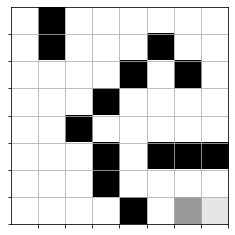

In [6]:
# Method call pass with object instances
completion_check(model, qmaze)

# Display maze to user
show(qmaze)

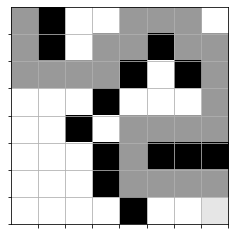

In [7]:
# Pirate start position used for testing trained model
pirate_start = (0, 0)

# Method call passed with object instances and start position
play_game(model, qmaze, pirate_start)

# Output pirate movement to user
show(qmaze)